In [167]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import font_manager
import seaborn as sns
from scipy import stats, optimize, integrate
from copy import copy
import pandas as pd
import datetime
from statsmodels.graphics.gofplots import qqplot

In [2]:
%matplotlib inline

label_font = font_manager.FontProperties(
    family=['Fira Sans'],
    weight='regular',
    size=20
)
tick_font = font_manager.FontProperties(
    family=['Fira Sans'],
    weight='regular',
    size=14
)
pub_font = font_manager.FontProperties(
#     family=['cmr10'],
    weight='regular',
    size=32
)
publish = False
if publish:
    matplotlib.rcParams.update(
        {
            'text.usetex': True,
            'font.family': 'cmr10',
            'mathtext.fontset': 'cm',
        }
    )

In [3]:
def seir(t, y, p):
    b, g, e, d, a, m = p[:6]
    S,E,I,H,G,R,D,cE,cH = y[:9]
    return [
        -b*S*I/(S+E+I+R+G+H),
        b*S*I/(S+E+I+R+G+H)-g*E,
        g*E-(e+a+m)*I,
        e*I-d*H,
        d*H,
        e*I,
        m*I,
        g*E,
        e*I
    ]

In [4]:
read_file = True
if read_file:
    raw_data = pd.read_csv("../samoa-data/samoa_press_release_data.csv", 
                           header=0, dayfirst=True, parse_dates=True, skiprows=[1])

In [5]:
the_dates = list(map(lambda t: datetime.datetime.strptime(t, "%d/%m/%Y"), raw_data.Date.values))
def time_conv(time: float):
    return the_dates[0] + datetime.timedelta(days=time)

In [6]:
date_tick = [datetime.date(2019, M, 1) for M in [10, 11, 12]] + [datetime.date(2020, 1, 1)]
date_tick_label = ['Oct\n2019', 'Nov', 'Dec', 'Jan\n2020']

ex_date_tick = date_tick + [datetime.date(2020,2,1)]
ex_date_label = date_tick_label + ['Feb']

In [7]:
time, cE, H, cH, D, G = raw_data.iloc[:,1:].values.T

In [8]:
data_pd = np.vstack([H, G, D, cE, cH]).astype(float).T
start = 0
clip = 17
data_time = time[start:clip]
data_pd = data_pd[start:clip,:]

p0 = [2, 1e-6, 1e-6, 1e-6, 1e-6, 1e-6]
config = {
    "grid_size": 200,
    "basis_number": 40,
    "model_form": {
        "state": 9,
        "parameters": 6
    },
    "time_span": [time[0], time[-1]*1.25],
#     "time_span": [time[0], 150],
    "knot_function": None,
    "model": seir,
    "dataset": {"y": data_pd, "t": np.array(data_time)},
    "observation_vector": [3,4,6,7,8],
    "weightings":[
        [1]*9,
        np.sqrt((data_time+1)/np.mean(data_time+1))
    ],
    "regularisation_value": copy(p0),
}

In [9]:
model = modeller.Model(config)
config['regularisation_value'][0] = model.ps[0]
config['regularisation_value'][2] = model.ps[2]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 50,
        
    }
}
solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [10]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
fr_ex = ca.Function('fr_ex', [solver_setup['x']], [objective.regularisation])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)

In [11]:
c0 = [2500*np.ones(config['basis_number']) for _ in range(9)]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*9) + [0]*len(config['regularisation_value'])
alpha = 3e1

In [12]:
prange = np.logspace(-6, 6, num=100)
sols = []
xguess = x0
for p in prange[:51]:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-06

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0


 150 3.8268993e+001 0.00e+000 7.33e-001  -5.7 6.06e+003    -  8.48e-001 5.00e-001f  2
 200 3.8256390e+001 0.00e+000 4.86e-002  -5.7 1.53e+001    -  1.00e+000 1.00e+000f  1
 250 3.8254948e+001 0.00e+000 3.25e-003  -5.7 4.06e+000    -  1.00e+000 1.00e+000h  1
 300 3.8254576e+001 0.00e+000 7.87e-002  -5.7 1.35e+001    -  1.00e+000 1.00e+000h  1
 350 3.8253969e+001 0.00e+000 1.36e-003  -8.6 3.72e+000    -  1.00e+000 1.00e+000h  1
 400 3.8253863e+001 0.00e+000 6.65e-002  -8.6 3.77e+001    -  1.00e+000 1.00e+000h  1
 450 3.8253806e+001 0.00e+000 1.91e-003  -8.6 1.07e+001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 3.8253776e+001 0.00e+000 1.50e-002  -8.6 4.28e+001    -  1.00e+000 1.00e+000h  1
 550 3.8253757e+001 0.00e+000 3.44e-004  -8.6 1.04e+001    -  1.00e+000 1.00e+000h  1
 600 3.8253747e+001 0.00e+000 6.97e-002  -8.6 3.66e+002    -  1.00e+000 5.00e-001h  2
 650 3.8253737e+001 0.00e+000 1.65e-002  -8.6 2.33e+002    

1250 3.8341352e+001 0.00e+000 1.03e-002  -8.6 1.38e+003    -  1.00e+000 5.00e-001h  2
1300 3.8341351e+001 0.00e+000 2.67e-004  -8.6 1.28e+002    -  1.00e+000 1.00e+000h  1
1350 3.8341351e+001 0.00e+000 4.83e-003  -8.6 1.18e+003    -  1.00e+000 5.00e-001h  2
1400 3.8341351e+001 0.00e+000 2.63e-004  -8.6 1.60e+002    -  1.00e+000 1.00e+000h  1
1450 3.8341351e+001 0.00e+000 8.40e-003  -8.6 1.53e+004    -  1.00e+000 3.12e-002h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500 3.8341350e+001 0.00e+000 1.93e-003  -8.6 9.89e+002    -  1.00e+000 5.00e-001h  2
1550 3.8341350e+001 0.00e+000 8.11e-003  -8.6 2.27e+003    -  1.00e+000 5.00e-001h  2
1600 3.8341350e+001 0.00e+000 7.37e-004  -8.6 3.64e+002    -  1.00e+000 1.00e+000h  1
1650 3.8341350e+001 0.00e+000 8.58e-004  -8.6 4.11e+002    -  1.00e+000 1.00e+000h  1
1700 3.8341350e+001 0.00e+000 2.10e-003  -8.6 6.69e+002    -  1.00e+000 1.00e+000h  1
1750 3.8341350e+001 0.00e+000 1.88e-005  -8.6 7.28e+001    

1650 3.8445453e+001 0.00e+000 9.33e-003  -8.6 6.95e+003    -  1.00e+000 6.25e-002h  5
1700 3.8445453e+001 0.00e+000 6.84e-004  -8.6 2.98e+002    -  1.00e+000 1.00e+000h  1
1750 3.8445453e+001 0.00e+000 5.12e-004  -8.6 2.70e+002    -  1.00e+000 1.00e+000h  1
1800 3.8445452e+001 0.00e+000 1.21e-003  -8.6 4.30e+002    -  1.00e+000 1.00e+000h  1
1850 3.8445452e+001 0.00e+000 2.28e-003  -8.6 2.13e+003    -  1.00e+000 2.50e-001h  3
1900 3.8445452e+001 0.00e+000 8.59e-004  -8.6 3.93e+002    -  1.00e+000 1.00e+000h  1
1950 3.8445452e+001 0.00e+000 4.35e-003  -8.6 3.47e+003    -  1.00e+000 1.25e-001h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000 3.8445452e+001 0.00e+000 3.39e-003  -8.6 3.16e+003    -  1.00e+000 2.50e-001h  3
2050 3.8445452e+001 0.00e+000 6.47e-005  -8.6 1.24e+002    -  1.00e+000 1.00e+000h  1
2100 3.8445452e+001 0.00e+000 9.06e-003  -8.6 7.24e+003    -  1.00e+000 1.25e-001h  4
2150 3.8445452e+001 0.00e+000 3.85e-004  -8.6 3.12e+002    

1750 3.8567581e+001 0.00e+000 7.92e-004  -8.6 2.94e+002    -  1.00e+000 1.00e+000h  1
1800 3.8567581e+001 0.00e+000 7.92e-003  -8.6 9.63e+002    -  1.00e+000 1.00e+000h  1
1850 3.8567581e+001 0.00e+000 2.56e-004  -8.6 1.83e+002    -  1.00e+000 1.00e+000h  1
1900 3.8567581e+001 0.00e+000 4.36e-002  -8.6 1.86e+004    -  1.00e+000 3.12e-002h  6
1950 3.8567581e+001 0.00e+000 5.94e-005  -8.6 9.83e+001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000 3.8567580e+001 0.00e+000 1.01e-002  -8.6 2.51e+003    -  1.00e+000 5.00e-001h  2
2050 3.8567580e+001 0.00e+000 5.59e-006  -8.6 4.50e+001    -  1.00e+000 1.00e+000h  1
2100 3.8567580e+001 0.00e+000 8.50e-004  -8.6 3.96e+002    -  1.00e+000 1.00e+000h  1
2150 3.8567580e+001 0.00e+000 3.47e-003  -8.6 8.21e+002    -  1.00e+000 1.00e+000h  1
2200 3.8567580e+001 0.00e+000 1.07e-001  -8.6 4.50e+004    -  1.00e+000 1.56e-002h  7
2250 3.8567580e+001 0.00e+000 5.68e-003  -8.6 1.12e+003    

1750 3.8708380e+001 0.00e+000 9.97e-003  -8.6 2.44e+003    -  1.00e+000 1.25e-001h  4
1800 3.8708380e+001 0.00e+000 5.98e-003  -8.6 6.03e+002    -  1.00e+000 1.00e+000h  1
1850 3.8708380e+001 0.00e+000 4.87e-003  -8.6 1.08e+003    -  1.00e+000 5.00e-001h  2
1900 3.8708379e+001 0.00e+000 5.60e-005  -8.6 6.82e+001    -  1.00e+000 1.00e+000h  1
1950 3.8708379e+001 0.00e+000 2.91e-002  -8.6 6.65e+003    -  1.00e+000 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000 3.8708379e+001 0.00e+000 5.10e-003  -8.6 1.26e+003    -  1.00e+000 5.00e-001h  2
2050 3.8708379e+001 0.00e+000 7.16e-002  -8.6 1.59e+004    -  1.00e+000 3.12e-002h  6
2100 3.8708379e+001 0.00e+000 9.55e-005  -8.6 1.02e+002    -  1.00e+000 1.00e+000h  1
2150 3.8708379e+001 0.00e+000 5.54e-003  -8.6 7.74e+002    -  1.00e+000 1.00e+000h  1
2200 3.8708378e+001 0.00e+000 1.26e-003  -8.6 3.83e+002    -  1.00e+000 1.00e+000h  1
2250 3.8708378e+001 0.00e+000 4.83e-004  -8.6 2.46e+002    

1650 3.8867693e+001 0.00e+000 1.29e-003  -8.6 1.33e+002    -  1.00e+000 1.00e+000h  1
1700 3.8867693e+001 0.00e+000 5.61e-004  -8.6 9.86e+001    -  1.00e+000 1.00e+000h  1
1750 3.8867692e+001 0.00e+000 2.47e-003  -8.6 2.29e+002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 1785

                                   (scaled)                 (unscaled)
Objective...............:  3.8867691458159065e+001   3.8867691458159065e+001
Dual infeasibility......:  3.9636953256584995e-009   3.9636953256584995e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059036572383148e-009   2.5059036572383148e-009
Overall NLP error.......:  3.9636953256584995e-009   3.9636953256584995e-009


Number of objective function evaluations             = 3523
Number of objective gradient evaluations             = 1786
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 3523
Number of equa

  50 4.0683340e+001 0.00e+000 3.91e+001  -2.5 9.73e+003    -  1.00e+000 8.29e-001f  1
 100 4.1066597e+001 0.00e+000 1.56e+001  -2.5 1.90e+004    -  1.00e+000 1.00e+000f  1
 150 4.0234929e+001 0.00e+000 6.88e+000  -5.7 3.47e+003 -11.2 1.00e+000 1.00e+000f  1
 200 3.9438227e+001 0.00e+000 3.95e+000  -5.7 4.14e+003 -11.8 1.00e+000 7.88e-001f  1
 250 3.9260622e+001 0.00e+000 2.13e+000  -5.7 1.73e+002    -  1.00e+000 2.50e-001f  3
 300 3.9250709e+001 0.00e+000 8.93e-002  -5.7 3.16e+000    -  1.00e+000 1.00e+000f  1
 350 3.9247999e+001 0.00e+000 6.83e-002  -5.7 2.23e+000    -  1.00e+000 1.00e+000h  1
 400 3.9246813e+001 0.00e+000 1.37e-002  -5.7 1.82e+000    -  1.00e+000 1.00e+000h  1
 450 3.9246290e+001 0.00e+000 3.80e-002  -5.7 4.42e+000    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 3.9245967e+001 0.00e+000 2.99e-004  -5.7 9.62e-001    -  1.00e+000 1.00e+000f  1
 550 3.9245815e+001 0.00e+000 5.22e-002  -5.7 1.58e+002    

 850 3.9467295e+001 0.00e+000 5.91e-003  -8.6 1.66e+001    -  1.00e+000 1.00e+000h  1
 900 3.9467279e+001 0.00e+000 3.50e-003  -8.6 1.56e+001    -  1.00e+000 1.00e+000h  1
 950 3.9467266e+001 0.00e+000 3.34e-003  -8.6 1.86e+001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 3.9467256e+001 0.00e+000 5.86e-002  -8.6 3.64e+002    -  1.00e+000 2.50e-001h  3
1050 3.9467249e+001 0.00e+000 4.58e-002  -8.6 9.61e+001    -  1.00e+000 1.00e+000h  1
1100 3.9467243e+001 0.00e+000 4.66e-003  -8.6 3.57e+001    -  1.00e+000 1.00e+000h  1
1150 3.9467238e+001 0.00e+000 3.76e-003  -8.6 3.68e+001    -  1.00e+000 1.00e+000h  1
1200 3.9467234e+001 0.00e+000 1.73e-002  -8.6 8.96e+001    -  1.00e+000 1.00e+000h  1
1250 3.9467231e+001 0.00e+000 3.39e-002  -8.6 2.29e+003    -  1.00e+000 3.12e-002h  6
1300 3.9467228e+001 0.00e+000 1.40e-002  -8.6 1.86e+002    -  1.00e+000 5.00e-001h  2
1350 3.9467225e+001 0.00e+000 1.57e-005  -8.6 7.09e+000    

 850 3.9741638e+001 0.00e+000 1.79e-003  -8.6 7.98e+000    -  1.00e+000 1.00e+000h  1
 900 3.9741623e+001 0.00e+000 5.19e-003  -8.6 1.59e+001    -  1.00e+000 1.00e+000h  1
 950 3.9741617e+001 0.00e+000 2.73e-001  -8.6 1.34e+002    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 3.9741600e+001 0.00e+000 2.94e-003  -8.6 1.71e+001    -  1.00e+000 1.00e+000h  1
1050 3.9741591e+001 0.00e+000 5.28e-002  -8.6 2.45e+003    -  1.00e+000 3.12e-002h  6
1100 3.9743422e+001 0.00e+000 4.98e+000  -8.6 9.76e+002    -  1.00e+000 1.00e+000H  1
1150 3.9741579e+001 0.00e+000 7.40e-003  -8.6 4.43e+001    -  1.00e+000 1.00e+000h  1
1200 3.9741575e+001 0.00e+000 1.72e-002  -8.6 7.70e+001    -  1.00e+000 1.00e+000h  1
1250 3.9741567e+001 0.00e+000 8.01e-004  -8.6 2.38e+001    -  1.00e+000 1.00e+000h  1
1300 3.9741565e+001 0.00e+000 1.72e-003  -8.6 3.86e+001    -  1.00e+000 1.00e+000h  1
1350 3.9741563e+001 0.00e+000 4.19e-003  -8.6 6.61e+001    

 800 4.0093918e+001 0.00e+000 2.89e-002  -5.7 1.26e+001    -  1.00e+000 5.00e-001h  2
 850 4.0093510e+001 0.00e+000 8.95e-002  -8.6 1.51e+001    -  1.00e+000 1.00e+000h  1
 900 4.0093452e+001 0.00e+000 2.05e-002  -8.6 9.11e+000    -  1.00e+000 1.00e+000h  1
 950 4.0093408e+001 0.00e+000 2.26e-002  -8.6 1.18e+001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.0093376e+001 0.00e+000 6.27e-002  -8.6 2.35e+001    -  1.00e+000 1.00e+000h  1
1050 4.0093351e+001 0.00e+000 5.79e-002  -8.6 2.72e+001    -  1.00e+000 1.00e+000h  1
1100 4.0093330e+001 0.00e+000 1.10e-002  -8.6 1.41e+001    -  1.00e+000 1.00e+000h  1
1150 4.0093314e+001 0.00e+000 1.40e-002  -8.6 1.89e+001    -  1.00e+000 1.00e+000h  1
1200 4.0093300e+001 0.00e+000 5.00e-003  -8.6 1.33e+001    -  1.00e+000 1.00e+000h  1
1250 4.0093289e+001 0.00e+000 5.34e-002  -8.6 5.09e+001    -  1.00e+000 1.00e+000h  1
1300 4.0093280e+001 0.00e+000 2.95e-003  -8.6 1.39e+001    

 850 4.0529331e+001 0.00e+000 6.84e-002  -8.6 2.49e+001    -  1.00e+000 5.00e-001h  2
 900 4.0529297e+001 0.00e+000 1.40e-002  -8.6 8.00e+000    -  1.00e+000 1.00e+000h  1
 950 4.0529270e+001 0.00e+000 6.17e-004  -8.6 2.28e+000    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.0529248e+001 0.00e+000 2.48e-002  -8.6 1.47e+001    -  1.00e+000 1.00e+000h  1
1050 4.0529230e+001 0.00e+000 2.32e-003  -8.6 5.40e+000    -  1.00e+000 1.00e+000h  1
1100 4.0529216e+001 0.00e+000 3.89e-002  -8.6 2.49e+001    -  1.00e+000 1.00e+000h  1
1150 4.0529204e+001 0.00e+000 5.63e-003  -8.6 1.10e+001    -  1.00e+000 1.00e+000h  1
1200 4.0529194e+001 0.00e+000 6.17e-002  -8.6 3.23e+002    -  1.00e+000 1.25e-001h  4
1250 4.0529186e+001 0.00e+000 2.64e-002  -8.6 4.75e+002    -  1.00e+000 6.25e-002h  5
1300 4.0529179e+001 0.00e+000 7.09e-003  -8.6 1.81e+001    -  1.00e+000 1.00e+000h  1
1350 4.0529172e+001 0.00e+000 1.08e-004  -8.6 3.23e+000    

 900 4.1036830e+001 0.00e+000 4.91e-003  -5.7 1.60e+000    -  1.00e+000 1.00e+000h  1
 950 4.1036786e+001 0.00e+000 6.40e-002  -5.7 2.51e+001    -  1.00e+000 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.1036762e+001 0.00e+000 1.83e-003  -5.7 2.29e+000    -  1.00e+000 5.00e-001h  2
1050 4.1036287e+001 0.00e+000 1.91e-001  -8.6 1.39e+001    -  1.00e+000 1.00e+000h  1
1100 4.1036239e+001 0.00e+000 2.90e-001  -8.6 2.05e+001    -  1.00e+000 1.00e+000h  1
1150 4.1036198e+001 0.00e+000 1.18e-002  -8.6 4.98e+000    -  1.00e+000 1.00e+000h  1
1200 4.1036166e+001 0.00e+000 2.49e-001  -8.6 5.29e+001    -  1.00e+000 5.00e-001h  2
1250 4.1036140e+001 0.00e+000 1.71e-002  -8.6 8.30e+000    -  1.00e+000 1.00e+000h  1
1300 4.1036116e+001 0.00e+000 9.02e-003  -8.6 7.22e+000    -  1.00e+000 1.00e+000h  1
1350 4.1036099e+001 0.00e+000 8.26e-003  -8.6 8.04e+000    -  1.00e+000 1.00e+000h  1
1400 4.1036086e+001 0.00e+000 1.15e-002  -8.6 1.09e+001    

 800 4.1625884e+001 0.00e+000 1.99e-002  -5.7 2.43e+000    -  1.00e+000 1.00e+000h  1
 850 4.1625845e+001 0.00e+000 3.19e-002  -5.7 6.27e+000    -  1.00e+000 5.00e-001h  2
 900 4.1625824e+001 0.00e+000 1.51e-002  -5.7 9.78e+000    -  1.00e+000 2.50e-001h  3
 950 4.1625575e+001 0.00e+000 3.15e+000  -8.6 4.18e+001    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.1625297e+001 0.00e+000 1.70e-001  -8.6 2.19e+001    -  1.00e+000 5.00e-001h  2
1050 4.1625257e+001 0.00e+000 1.22e-001  -8.6 2.18e+001    -  1.00e+000 5.00e-001h  2
1100 4.1625230e+001 0.00e+000 1.06e-001  -8.6 1.27e+001    -  1.00e+000 1.00e+000h  1
1150 4.1625207e+001 0.00e+000 2.34e-001  -8.6 8.57e+001    -  1.00e+000 2.50e-001h  3
1200 4.1625187e+001 0.00e+000 8.72e-002  -8.6 2.80e+001    -  1.00e+000 5.00e-001h  2
1250 4.1625172e+001 0.00e+000 1.17e-001  -8.6 7.76e+001    -  1.00e+000 2.50e-001h  3
1300 4.1625159e+001 0.00e+000 2.76e-001  -8.6 6.93e+001    

 850 4.2970625e+001 0.00e+000 2.83e-001  -5.7 3.47e+001    -  1.00e+000 5.00e-001h  2
 900 4.2970519e+001 0.00e+000 3.07e-001  -5.7 4.39e+001    -  1.00e+000 5.00e-001h  2
 950 4.2970449e+001 0.00e+000 1.75e-002  -5.7 6.15e+000    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.2970399e+001 0.00e+000 5.30e-002  -5.7 1.19e+001    -  1.00e+000 1.00e+000h  1
1050 4.2970364e+001 0.00e+000 2.35e-003  -5.7 2.76e+000    -  1.00e+000 1.00e+000h  1
1100 4.2970146e+001 0.00e+000 1.78e-001  -8.6 2.44e+002    -  8.68e-001 5.23e-001f  1
1150 4.2969945e+001 0.00e+000 2.92e-002  -8.6 1.33e+001    -  1.00e+000 1.00e+000h  1
1200 4.2969899e+001 0.00e+000 1.08e-001  -8.6 1.11e+002    -  1.00e+000 2.50e-001h  3
1250 4.2969865e+001 0.00e+000 1.46e-001  -8.6 4.12e+001    -  1.00e+000 1.00e+000h  1
1300 4.2969836e+001 0.00e+000 2.92e-003  -8.6 7.09e+000    -  1.00e+000 1.00e+000h  1
1350 4.2969786e+001 0.00e+000 1.71e-003  -8.6 7.81e+000    

 900 4.3813441e+001 0.00e+000 6.01e-001  -5.7 7.39e+001    -  1.00e+000 1.25e-001h  4
 950 4.3813120e+001 0.00e+000 1.97e+000  -5.7 4.37e+001    -  1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.3812785e+001 0.00e+000 4.64e-003  -5.7 1.50e+000    -  1.00e+000 1.00e+000h  1
1050 4.3812591e+001 0.00e+000 3.73e-001  -5.7 2.88e+001    -  1.00e+000 5.00e-001h  2
1100 4.3812452e+001 0.00e+000 2.13e-001  -5.7 2.14e+002    -  1.00e+000 6.25e-002h  5
1150 4.3812344e+001 0.00e+000 3.35e-002  -5.7 6.40e+000    -  1.00e+000 1.00e+000h  1
1200 4.3812267e+001 0.00e+000 1.63e-002  -5.7 5.15e+000    -  1.00e+000 1.00e+000h  1
1250 4.3812206e+001 0.00e+000 1.29e-001  -5.7 6.34e+001    -  1.00e+000 2.50e-001h  3
1300 4.3811792e+001 0.00e+000 3.12e-002  -8.6 1.08e+001    -  1.00e+000 1.00e+000h  1
1350 4.3811739e+001 0.00e+000 2.69e-002  -8.6 1.19e+001    -  1.00e+000 1.00e+000h  1
1400 4.3811695e+001 0.00e+000 1.76e-002  -8.6 1.14e+001    

 800 4.4759847e+001 0.00e+000 2.86e-001  -5.7 1.84e+000    -  1.00e+000 1.00e+000f  1
 850 4.4758198e+001 0.00e+000 1.28e-001  -5.7 1.76e+000    -  1.00e+000 1.00e+000h  1
 900 4.4757097e+001 0.00e+000 2.33e-001  -5.7 3.26e+000    -  1.00e+000 1.00e+000h  1
 950 4.4756369e+001 0.00e+000 5.52e-001  -5.7 1.05e+002    -  1.00e+000 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 4.4755876e+001 0.00e+000 1.04e-002  -5.7 1.30e+000    -  1.00e+000 1.00e+000f  1
1050 4.4755544e+001 0.00e+000 1.95e-001  -5.7 6.58e+000    -  1.00e+000 1.00e+000h  1
1100 4.4755292e+001 0.00e+000 3.08e-001  -5.7 1.03e+001    -  1.00e+000 1.00e+000h  1
1150 4.4755110e+001 0.00e+000 1.65e-002  -5.7 2.95e+000    -  1.00e+000 1.00e+000h  1
1200 4.4754978e+001 0.00e+000 6.53e-003  -5.7 2.24e+000    -  1.00e+000 1.00e+000h  1
1250 4.4754864e+001 0.00e+000 1.05e-001  -5.7 1.60e+002    -  1.00e+000 6.25e-002h  5
1300 4.4754785e+001 0.00e+000 7.95e-002  -5.7 1.03e+001    


Number of Iterations....: 695

                                   (scaled)                 (unscaled)
Objective...............:  4.6870197880305589e+001   4.6870197880305589e+001
Dual infeasibility......:  4.9150491620282513e-009   4.9150491620282513e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.2299528459699172e-010   9.2299528459699172e-010
Overall NLP error.......:  4.9150491620282513e-009   4.9150491620282513e-009


Number of objective function evaluations             = 1172
Number of objective gradient evaluations             = 696
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1172
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 696
Number of Lagrangian Hessian evaluations             = 695
Total CPU secs in IPOPT (w/o function evaluations)   =      7.437
Total CPU secs in NLP function ev

  50 5.1810880e+001 0.00e+000 1.74e+001  -2.5 1.81e+004    -  7.03e-001 2.50e-001f  3
 100 5.1104497e+001 0.00e+000 1.30e+000  -3.8 1.67e+004 -13.0 1.00e+000 2.56e-002f  5
 150 5.1072231e+001 0.00e+000 5.67e-001  -5.7 2.66e+002 -11.5 1.00e+000 1.00e+000f  1
 200 5.1056805e+001 0.00e+000 6.21e-001  -5.7 5.01e+002 -11.9 1.00e+000 1.00e+000f  1
 250 5.1029555e+001 0.00e+000 4.91e+000  -5.7 3.53e+002 -11.4 1.00e+000 1.00e+000f  1
 300 5.0992404e+001 0.00e+000 1.50e+000  -5.7 3.82e+002 -11.7 1.00e+000 1.00e+000f  1
 350 5.0965979e+001 0.00e+000 3.68e+001  -5.7 1.74e+005    -  6.70e-003 1.18e-002f  1
 400 5.0954866e+001 0.00e+000 5.75e-002  -8.6 6.78e+001 -12.0 1.00e+000 9.94e-001f  1

Number of Iterations....: 431

                                   (scaled)                 (unscaled)
Objective...............:  5.0954443258263069e+001   5.0954443258263069e+001
Dual infeasibility......:  1.1679889013332752e-010   1.1679889013332752e-010
Constraint violation....:  0.0000000000000000e+000   0.

  50 9.2672422e+001 0.00e+000 3.63e+002  -1.0 4.72e+003    -  1.00e+000 1.00e+000f  1
 100 5.8164848e+001 0.00e+000 9.76e+001  -3.8 1.05e+004  -9.9 1.58e-001 2.14e-001f  3
 150 5.6962738e+001 0.00e+000 6.10e+001  -3.8 1.18e+003 -10.5 1.00e+000 1.00e+000f  1
 200 5.6916058e+001 0.00e+000 7.94e+000  -3.8 5.40e+003    -  1.00e+000 5.00e-001f  2
 250 5.6901436e+001 0.00e+000 3.52e-001  -3.8 2.03e+002    -  1.00e+000 5.00e-001h  2
 300 5.6850050e+001 0.00e+000 2.69e+001  -5.7 8.69e+002 -12.0 1.00e+000 1.00e+000f  1
 350 5.6798811e+001 0.00e+000 1.12e+001  -5.7 8.34e+002 -11.5 1.00e+000 1.00e+000f  1
 400 5.6730115e+001 0.00e+000 3.71e+001  -5.7 6.30e+002 -11.0 1.00e+000 1.00e+000f  1
 450 5.6673132e+001 0.00e+000 5.07e+000  -5.7 4.64e+002 -11.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 5.6653039e+001 0.00e+000 1.74e+001  -5.7 7.24e+003    -  5.11e-001 1.19e-001f  1
 550 5.6651513e+001 0.00e+000 3.89e-002  -8.6 2.15e+003 -14

 350 6.2853165e+001 0.00e+000 9.32e+000  -3.8 5.46e+002 -12.1 1.00e+000 5.00e-001f  2
 400 6.2807145e+001 0.00e+000 2.64e+000  -3.8 5.64e+002 -12.1 1.00e+000 1.00e+000f  1
 450 6.2746329e+001 0.00e+000 3.87e+001  -3.8 1.61e+003 -12.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 6.2683856e+001 0.00e+000 2.83e+001  -3.8 3.40e+002 -11.9 1.00e+000 1.00e+000f  1
 550 6.2628644e+001 0.00e+000 8.00e+000  -5.7 2.32e+002 -10.5 1.00e+000 1.00e+000f  1
 600 6.2619259e+001 0.00e+000 5.77e+000  -5.7 3.76e+002 -11.6 1.00e+000 1.00e+000f  1

Number of Iterations....: 644

                                   (scaled)                 (unscaled)
Objective...............:  6.2618194857722564e+001   6.2618194857722564e+001
Dual infeasibility......:  6.8493951594147911e-011   6.8493951594147911e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5066410241613520e-009   2.50664102416135

  50 1.1179443e+002 0.00e+000 3.46e+002  -1.0 3.00e+003    -  1.00e+000 5.00e-001f  2
 100 8.4841933e+001 0.00e+000 7.64e+001  -2.5 2.02e+003 -11.3 1.00e+000 1.00e+000f  1
 150 8.1529558e+001 0.00e+000 2.22e+002  -2.5 3.00e+003  -9.1 1.00e+000 5.00e-001f  2
 200 7.7001803e+001 0.00e+000 2.51e+001  -2.5 1.57e+003    -  1.00e+000 5.00e-001f  2
 250 7.6204986e+001 0.00e+000 3.28e+001  -3.8 4.67e+004    -  1.00e+000 6.25e-002f  5
 300 7.6182023e+001 0.00e+000 2.68e+001  -3.8 1.85e+003 -10.9 1.00e+000 5.00e-001f  2
 350 7.6154887e+001 0.00e+000 2.33e+001  -3.8 1.14e+004 -12.0 3.55e-001 6.25e-002f  5
 400 7.6113015e+001 0.00e+000 6.79e+001  -3.8 1.71e+003 -11.7 1.00e+000 5.00e-001f  2
 450 7.6051250e+001 0.00e+000 5.94e+001  -3.8 4.39e+002 -12.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 7.5980236e+001 0.00e+000 1.12e+001  -3.8 1.63e+002 -11.4 1.00e+000 1.00e+000f  1
 550 7.5934962e+001 0.00e+000 1.93e+000  -3.8 2.20e+002 -11

 450 8.6558351e+001 0.00e+000 5.65e+001  -3.8 4.08e+002 -11.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 8.6468670e+001 0.00e+000 3.67e+001  -3.8 2.70e+002 -11.0 1.00e+000 1.00e+000f  1
 550 8.6392410e+001 0.00e+000 6.67e+001  -3.8 1.13e+003 -11.4 1.00e+000 2.50e-001f  3
 600 8.6342658e+001 0.00e+000 5.56e+000  -3.8 9.57e+001 -11.2 1.00e+000 1.00e+000f  1
 650 8.6294377e+001 0.00e+000 5.33e+000  -5.7 5.31e+002 -11.3 1.00e+000 1.00e+000f  1
 700 8.6290540e+001 0.00e+000 4.24e-008  -8.6 5.19e-001    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 701

                                   (scaled)                 (unscaled)
Objective...............:  8.6290539707256656e+001   8.6290539707256656e+001
Dual infeasibility......:  2.6581403744785348e-011   2.6581403744785348e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035596800568e-009   2.50590355968005

  50 1.2909487e+002 0.00e+000 2.09e+003  -1.0 1.30e+003  -8.9 1.00e+000 1.00e+000f  1
 100 1.0821750e+002 0.00e+000 6.05e+000  -1.7 8.37e+001  -9.5 1.00e+000 1.00e+000f  1
 150 1.0456279e+002 0.00e+000 6.58e+001  -3.8 3.31e+002 -10.1 1.00e+000 1.00e+000f  1
 200 1.0454598e+002 0.00e+000 3.29e+000  -3.8 5.21e+001  -9.9 1.00e+000 1.00e+000f  1
 250 1.0453059e+002 0.00e+000 5.43e-001  -3.8 8.14e+001 -10.2 1.00e+000 1.00e+000f  1
 300 1.0451078e+002 0.00e+000 8.08e+001  -3.8 1.55e+005    -  2.92e-001 9.60e-003f  5
 350 1.0447620e+002 0.00e+000 6.47e+001  -3.8 4.95e+002 -10.9 1.00e+000 1.00e+000f  1
 400 1.0440672e+002 0.00e+000 6.99e+001  -3.8 3.45e+002 -10.4 1.00e+000 1.00e+000f  1
 450 1.0426105e+002 0.00e+000 1.00e+002  -3.8 6.50e+002 -10.7 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.0402139e+002 0.00e+000 1.44e+001  -3.8 1.28e+002 -10.2 1.00e+000 1.00e+000f  1
 550 1.0384323e+002 0.00e+000 2.68e+001  -3.8 4.30e+004    

 350 1.1783646e+002 0.00e+000 1.25e+000  -3.8 1.47e+002 -10.1 1.00e+000 1.00e+000f  1
 400 1.1780427e+002 0.00e+000 2.61e+000  -3.8 4.55e+002 -10.5 1.00e+000 1.00e+000f  1
 450 1.1775325e+002 0.00e+000 6.68e-001  -3.8 3.09e+001  -9.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.1769196e+002 0.00e+000 3.13e+000  -3.8 1.02e+002  -9.5 1.00e+000 1.00e+000f  1
 550 1.1757452e+002 0.00e+000 1.39e+001  -3.8 2.03e+003  -9.8 1.00e+000 3.12e-002f  6
 600 1.1738630e+002 0.00e+000 6.20e+001  -3.8 3.41e+002  -9.3 1.00e+000 1.00e+000f  1
 650 1.1686412e+002 0.00e+000 1.49e+001  -3.8 2.03e+002  -8.8 1.00e+000 1.00e+000f  1
 700 1.1624353e+002 0.00e+000 6.18e-002  -3.8 1.23e+001  -8.2 1.00e+000 1.00e+000f  1
 750 1.1623421e+002 0.00e+000 6.07e+001  -3.8 1.24e+003    -  1.00e+000 1.00e+000f  1
 800 1.1621851e+002 0.00e+000 2.91e+000  -5.7 1.26e+001  -9.4 1.00e+000 1.00e+000f  1

Number of Iterations....: 829

                           

 350 1.3361406e+002 0.00e+000 4.35e+000  -3.8 2.40e+002  -9.9 1.00e+000 1.00e+000f  1
 400 1.3352543e+002 0.00e+000 1.89e-001  -3.8 1.03e+002  -9.4 1.00e+000 1.00e+000f  1
 450 1.3337148e+002 0.00e+000 2.04e-001  -3.8 3.32e+000  -7.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.3310941e+002 0.00e+000 7.76e-002  -3.8 3.65e+001  -8.3 1.00e+000 1.00e+000f  1
 550 1.3261001e+002 0.00e+000 3.57e+000  -3.8 2.12e+002  -8.7 1.00e+000 1.00e+000f  1
 600 1.3095901e+002 0.00e+000 8.79e-001  -3.8 1.13e+001  -6.4 1.00e+000 1.00e+000f  1
 650 1.3053564e+002 0.00e+000 1.85e-001  -8.6 1.11e+001 -11.2 1.00e+000 9.97e-001h  1

Number of Iterations....: 655

                                   (scaled)                 (unscaled)
Objective...............:  1.3053558312458378e+002   1.3053558312458378e+002
Dual infeasibility......:  2.4484035651656967e-010   2.4484035651656967e-010
Constraint violation....:  0.0000000000000000e+000   0.00000

 500 1.5314705e+002 0.00e+000 9.71e-002  -3.8 2.98e+001  -8.3 1.00e+000 1.00e+000f  1
 550 1.5222942e+002 0.00e+000 3.95e-001  -3.8 3.17e+001  -7.8 1.00e+000 1.00e+000f  1
 600 1.4946103e+002 0.00e+000 6.96e+001  -3.8 3.27e+002  -8.2 1.00e+000 1.00e+000f  1
 650 1.4837593e+002 0.00e+000 1.59e-007  -8.6 5.85e+000    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 651

                                   (scaled)                 (unscaled)
Objective...............:  1.4837592986560739e+002   1.4837592986560739e+002
Dual infeasibility......:  4.7659564642981491e-010   4.7659564642981491e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5122630481077647e-009   2.5122630481077647e-009
Overall NLP error.......:  2.5122630481077647e-009   2.5122630481077647e-009


Number of objective function evaluations             = 1262
Number of objective gradient evaluations             = 652
Number of equality constraint evaluations      

  50 2.3212418e+002 0.00e+000 4.96e+003  -1.0 3.46e+003    -  6.16e-001 1.00e+000f  1
 100 2.2561080e+002 0.00e+000 2.25e+003  -1.0 6.34e+003  -8.4 7.28e-001 1.23e-001f  3
 150 2.2514869e+002 0.00e+000 2.00e+002  -1.0 2.58e+002    -  1.00e+000 5.00e-001f  2
 200 2.1321284e+002 0.00e+000 5.34e+001  -1.7 5.46e+001    -  1.00e+000 1.00e+000f  1
 250 2.1002338e+002 0.00e+000 1.07e+003  -3.8 4.49e+002  -8.5 1.00e+000 5.00e-001f  2
 300 2.0777593e+002 0.00e+000 1.44e+003  -3.8 4.77e+002  -8.0 1.00e+000 5.00e-001f  2
 350 2.0439997e+002 0.00e+000 2.04e+001  -3.8 2.11e+001  -6.6 1.00e+000 1.00e+000f  1
 400 2.0032382e+002 0.00e+000 2.08e+002  -3.8 7.12e+001  -7.0 1.00e+000 1.00e+000f  1
 450 1.9837441e+002 0.00e+000 6.77e+000  -3.8 9.37e+001  -7.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.9608132e+002 0.00e+000 3.91e+002  -3.8 7.32e+002  -8.6 1.00e+000 1.00e+000f  1
 550 1.9540002e+002 0.00e+000 2.84e-001  -3.8 1.88e+001  -8

 450 2.4738092e+002 0.00e+000 2.60e+001  -2.5 4.87e+001  -6.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 2.4178118e+002 0.00e+000 6.78e-001  -2.5 1.05e+001  -6.0 1.00e+000 1.00e+000f  1
 550 2.3773879e+002 0.00e+000 1.14e+000  -2.5 1.52e+001  -6.4 1.00e+000 1.00e+000f  1
 600 2.3419339e+002 0.00e+000 4.91e-001  -2.5 2.86e+001  -7.0 1.00e+000 1.00e+000f  1
 650 2.3077517e+002 0.00e+000 1.57e-001  -3.8 1.83e+000  -4.7 1.00e+000 1.00e+000f  1
 700 2.2381716e+002 0.00e+000 2.29e-001  -3.8 1.24e+000  -4.1 1.00e+000 1.00e+000f  1
 750 2.2131259e+002 0.00e+000 4.52e-008  -8.6 2.57e+000    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 753

                                   (scaled)                 (unscaled)
Objective...............:  2.2131259486857653e+002   2.2131259486857653e+002
Dual infeasibility......:  6.5481592482619236e-010   6.5481592482619236e-010
Constraint violation....:  0.0000000000000000e+000   0.00000


Number of Iterations....: 29

                                   (scaled)                 (unscaled)
Objective...............:  2.9876537039004228e+002   2.9876537039004228e+002
Dual infeasibility......:  1.8501586081004425e-009   1.8501586081004425e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.4455544800389814e-009   1.4455544800389814e-009
Overall NLP error.......:  1.8501586081004425e-009   1.8501586081004425e-009


Number of objective function evaluations             = 43
Number of objective gradient evaluations             = 30
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 43
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 30
Number of Lagrangian Hessian evaluations             = 29
Total CPU secs in IPOPT (w/o function evaluations)   =      0.248
Total CPU secs in NLP function evaluation

In [13]:
idx = 50

(DM(19.3124), DM(0.579463), DM(0.225398), DM(0.230009), DM(0.610375), DM(0.0152926))


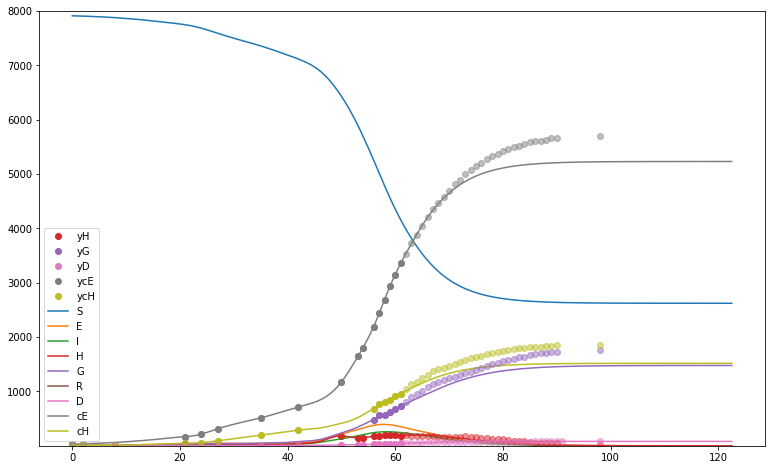

In [14]:
fig, ax=plt.subplots(figsize=[13, 8])
dColours = plt.rcParams['axes.prop_cycle'].by_key()['color']
for clr, data_dots in zip([3,4,6,7,8],[H,G,D,cE,cH]):
    ax.plot(time[start:clip], data_dots[start:clip], 'o', color=dColours[clr])
for clr, data_stripe in zip(dColours, getx(sols[idx]['x'])):
    ax.plot(model.observation_times, data_stripe, color=clr)
for clr, data_dots in zip([3,4,6,7,8],[H,G,D,cE,cH]):
    ax.plot(time, data_dots, 'o', alpha=0.5, color=dColours[clr])
plt.legend(['yH', 'yG', 'yD', 'ycE', 'ycH', 'S', 'E', 'I', 'H', 'G', 'R', 'D', 'cE', 'cH'])
plt.ylim([1e-5, 8000])
# plt.yscale('log')
print(getp(sols[idx]['x']))

In [15]:
solref = sols[idx]['x']

xref = getx(solref)
pref = getp(solref)

# Data resampling

In [16]:
regen_params = []
for obs, i, cm in zip(objective.observations, config['observation_vector'], objective.collocation_matrices):
    cmfilter = np.diag(cm) == 1
    comp = ca.interp1d(model.observation_times,xref[i],objective.observation_times).toarray().flatten()[cmfilter]
    delta = np.log(obs[cmfilter]+1) - np.log(comp+1)
    mu = np.mean(delta)
    xd = (np.log(obs[cmfilter]+1) - np.log(comp+1) - mu).reshape(-1,1)
    cov = xd.T@xd
    regen_params.append((comp, mu, cov, cmfilter))
    

(0.866400957107544, 0.0468297079205513)
(0.9493730664253235, 0.6610886454582214)
(0.9657568335533142, 0.7407469153404236)
(0.9092743992805481, 0.11327839642763138)
(0.8929452300071716, 0.0891411155462265)


<Figure size 432x288 with 0 Axes>

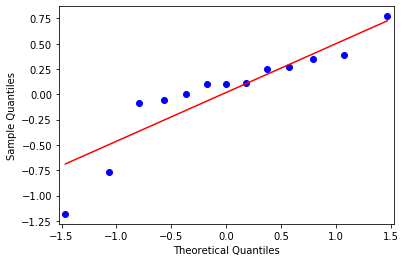

<Figure size 432x288 with 0 Axes>

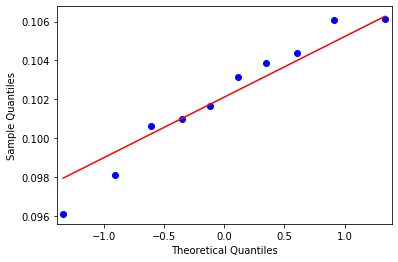

<Figure size 432x288 with 0 Axes>

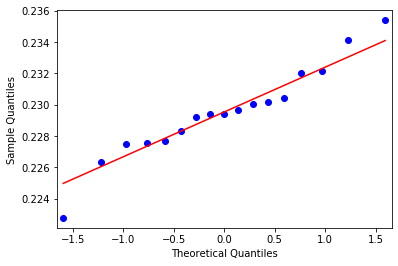

<Figure size 432x288 with 0 Axes>

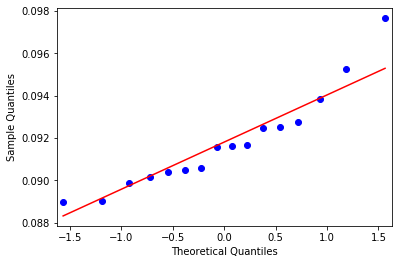

<Figure size 432x288 with 0 Axes>

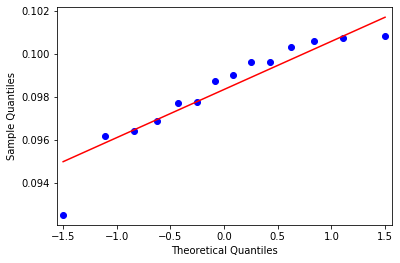

In [148]:
for obs, i, cm in zip(objective.observations, config['observation_vector'], objective.collocation_matrices):
    cmfilter = np.diag(cm) == 1
    comp = ca.interp1d(model.observation_times,xref[i],objective.observation_times).toarray().flatten()[cmfilter]
    delta = np.log(obs[cmfilter]+1) - np.log(comp+1)
#     plt.plot(data_time[cmfilter], delta, 'o--')
    plt.figure();
    qqplot(delta, line='s');
    print(stats.shapiro(delta));

In [18]:
def resampler(params):
    out = []
    for x, m, cv, ci in params:
        mx = (np.log(x+1)+m)
        temp = np.empty((len(ci)))
        temp[:] = np.nan
        temp[ci] = np.exp(np.random.randn(*mx.shape)*np.sqrt(cv)+mx).flatten() - 1
        out.append(temp)
    return out

In [19]:
yd = [resampler(regen_params) for _ in range(200)]

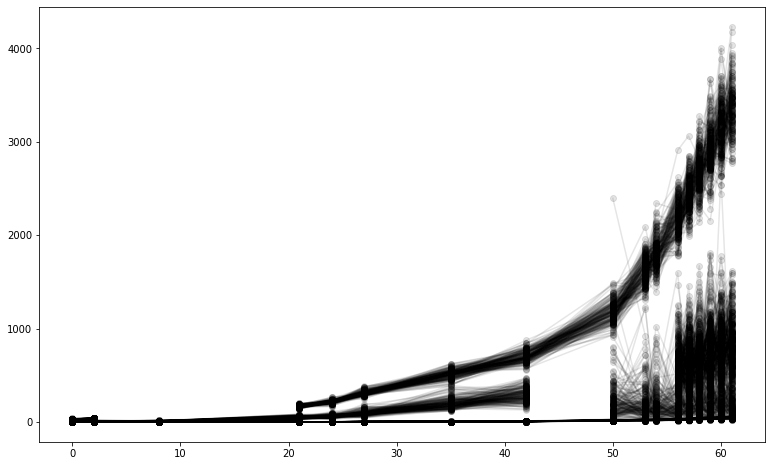

In [20]:
plt.figure(figsize=[13,8])
for y in yd:
    for x in y:
        plt.plot(objective.observation_times, x, 'ko-', alpha=0.1)

In [21]:
rho = prange[idx]
resolves = []
for y in yd:
    # construct problem
    dpd = np.vstack(y).T
    objective.observations = objective.observations_from_pandas(dpd)
    objective.create_objective(model)
    isetup = {
        'f': objective.objective,
        'x': ca.vcat(objective.input_list),
        'p': ca.hcat([objective.rho, objective.alpha]),
        'g': ca.vcat(model.xs),
    }
    isolver = ca.nlpsol('solver', 'ipopt', isetup, ipopt_opts)
    isolve_opts = {
        'x0': solref,
        'p': [rho, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    resolves.append(isolver(**isolve_opts))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

2450 7.4653445e+004 0.00e+000 6.89e+000  -3.8 2.35e+001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500 7.4653444e+004 0.00e+000 5.29e+000  -3.8 2.10e+001    -  1.00e+000 1.00e+000h  1
2550 7.4653442e+004 0.00e+000 1.18e+000  -3.8 1.01e+001    -  1.00e+000 1.00e+000h  1
2600 7.4653441e+004 0.00e+000 2.84e+001  -3.8 5.12e+001    -  1.00e+000 5.00e-001h  2
2650 7.4653440e+004 0.00e+000 8.32e+001  -3.8 9.98e+001    -  1.00e+000 2.50e-001h  3
2700 7.4653440e+004 0.00e+000 1.65e-002  -3.8 1.28e+000    -  1.00e+000 1.00e+000h  1
2750 7.4653439e+004 0.00e+000 1.65e-002  -3.8 1.26e+000    -  1.00e+000 1.00e+000h  1
2800 7.4653419e+004 0.00e+000 1.80e+001  -5.7 4.23e+001    -  1.00e+000 1.00e+000h  1
2850 7.4653417e+004 0.00e+000 1.67e+001  -5.7 4.20e+001    -  1.00e+000 1.00e+000h  1
2900 7.4653416e+004 0.00e+000 1.57e+000  -5.7 1.36e+001    -  1.00e+000 1.00e+000f  1
2950 7.4653414e+004 0.00e+000 3.82e+002  -5.7 3.94e+002    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

 900 3.2213263e+004 0.00e+000 1.56e+001  -3.8 7.85e+000    -  1.00e+000 1.00e+000f  1
 950 3.2213178e+004 0.00e+000 2.54e+001  -3.8 1.17e+001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 3.2213109e+004 0.00e+000 7.95e+000  -3.8 7.63e+000    -  1.00e+000 1.00e+000f  1
1050 3.2213054e+004 0.00e+000 9.57e+001  -3.8 1.16e+002    -  1.00e+000 2.50e-001f  3
1100 3.2213007e+004 0.00e+000 6.52e+001  -3.8 5.22e+001    -  1.00e+000 5.00e-001f  2
1150 3.2212968e+004 0.00e+000 2.31e+001  -3.8 1.92e+001    -  1.00e+000 1.00e+000f  1
1200 3.2212935e+004 0.00e+000 2.24e+001  -3.8 2.13e+001    -  1.00e+000 1.00e+000f  1
1250 3.2212907e+004 0.00e+000 7.68e+001  -3.8 1.65e+002    -  1.00e+000 2.50e-001f  3
1300 3.2212883e+004 0.00e+000 3.07e+001  -3.8 5.21e+001    -  1.00e+000 5.00e-001f  2
1350 3.2212862e+004 0.00e+000 2.19e+001  -3.8 2.78e+001    -  1.00e+000 1.00e+000f  1
1400 3.2212844e+004 0.00e+000 8.47e+000  -3.8 1.83e+001    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

2500 3.2150715e+004 0.00e+000 3.25e+001  -5.7 6.57e+001    -  1.00e+000 1.00e+000h  1
2550 3.2150714e+004 0.00e+000 4.02e+002  -5.7 2.28e+002    -  1.00e+000 5.00e-001h  2
2600 3.2150712e+004 0.00e+000 1.33e+000  -5.7 1.47e+001    -  1.00e+000 1.00e+000f  1
2650 3.2150710e+004 0.00e+000 5.06e+002  -5.7 2.86e+002    -  1.00e+000 5.00e-001h  2
2700 3.2150708e+004 0.00e+000 7.39e+000  -5.7 3.58e+001    -  1.00e+000 1.00e+000f  1
2750 3.2150707e+004 0.00e+000 2.68e+002  -5.7 2.21e+002    -  1.00e+000 1.00e+000H  1
2800 3.2150705e+004 0.00e+000 1.42e+004  -5.7 4.15e+003    -  1.00e+000 3.12e-002f  6
2850 3.2150704e+004 0.00e+000 8.97e+001  -5.7 1.36e+002    -  1.00e+000 1.00e+000h  1
2900 3.2150702e+004 0.00e+000 1.19e+000  -5.7 1.70e+001    -  1.00e+000 1.00e+000f  1
2950 3.2150701e+004 0.00e+000 5.76e+000  -5.7 3.72e+001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000 3.2150700e+004 0.00e+000 4.53e+000  -5.7 3.40e+001    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

1000 1.0548195e+005 0.00e+000 6.58e+001  -3.8 2.71e+001    -  1.00e+000 5.00e-001f  2
1050 1.0548193e+005 0.00e+000 1.19e+002  -3.8 4.88e+001    -  1.00e+000 5.00e-001f  2
1100 1.0548191e+005 0.00e+000 3.00e+002  -3.8 8.22e+001    -  1.00e+000 2.50e-001f  3
1150 1.0548189e+005 0.00e+000 3.67e+001  -3.8 3.13e+001    -  1.00e+000 1.00e+000f  1
1200 1.0548188e+005 0.00e+000 9.97e+000  -3.8 1.75e+001    -  1.00e+000 1.00e+000f  1
1250 1.0548187e+005 0.00e+000 4.34e+002  -3.8 1.19e+002    -  1.00e+000 2.50e-001f  3
1300 1.0548186e+005 0.00e+000 5.07e+002  -3.8 1.39e+002    -  1.00e+000 2.50e-001f  3
1350 1.0548186e+005 0.00e+000 1.03e+002  -3.8 4.24e+001    -  1.00e+000 5.00e-001f  2
1400 1.0548185e+005 0.00e+000 7.51e+000  -3.8 1.88e+001    -  1.00e+000 1.00e+000f  1
1450 1.0548185e+005 0.00e+000 2.78e+001  -3.8 3.76e+001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500 1.0548184e+005 0.00e+000 1.05e+002  -3.8 4.32e+001    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

2350 4.6292926e+004 0.00e+000 6.48e+000  -3.8 1.76e+001    -  1.00e+000 1.00e+000h  1
2400 4.6292923e+004 0.00e+000 1.08e+000  -3.8 7.46e+000    -  1.00e+000 1.00e+000h  1
2450 4.6292921e+004 0.00e+000 1.75e+000  -3.8 9.72e+000    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500 4.6292918e+004 0.00e+000 9.49e-001  -3.8 7.37e+000    -  1.00e+000 1.00e+000h  1
2550 4.6292917e+004 0.00e+000 1.75e+000  -3.8 1.02e+001    -  1.00e+000 1.00e+000h  1
2600 4.6292915e+004 0.00e+000 5.32e+000  -3.8 1.82e+001    -  1.00e+000 1.00e+000h  1
2650 4.6292913e+004 0.00e+000 2.65e-001  -3.8 4.22e+000    -  1.00e+000 1.00e+000h  1
2700 4.6292892e+004 0.00e+000 4.32e+000  -5.7 1.73e+001    -  1.00e+000 1.00e+000f  1
2750 4.6292890e+004 0.00e+000 4.89e+000  -5.7 1.90e+001    -  1.00e+000 1.00e+000f  1
2800 4.6292888e+004 0.00e+000 1.12e+001  -5.7 2.95e+001    -  1.00e+000 1.00e+000h  1
2850 4.6292887e+004 0.00e+000 8.83e+002  -5.7 6.56e+002    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

2400 4.7345833e+004 0.00e+000 1.08e+002  -8.6 2.50e+003    -  1.00e+000 5.00e-001h  2
2450 4.7345833e+004 0.00e+000 3.59e+001  -8.6 8.61e+002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500 4.7345833e+004 0.00e+000 8.39e+001  -8.6 1.37e+003    -  1.00e+000 1.00e+000h  1
2550 4.7345832e+004 0.00e+000 8.00e+002  -8.6 8.70e+003    -  1.00e+000 5.00e-001h  2
2600 4.7345832e+004 0.00e+000 7.97e+000  -8.6 4.70e+002    -  1.00e+000 1.00e+000h  1
2650 4.7345832e+004 0.00e+000 3.77e+001  -8.6 1.05e+003    -  1.00e+000 1.00e+000h  1
2700 4.7345832e+004 0.00e+000 1.05e+003  -8.6 2.17e+004    -  1.00e+000 2.50e-001h  3
2750 4.7345832e+004 0.00e+000 2.79e+001  -8.6 9.88e+002    -  1.00e+000 1.00e+000h  1
2800 4.7345832e+004 0.00e+000 2.52e+002  -8.6 5.56e+003    -  1.00e+000 5.00e-001h  2
2850 4.7345832e+004 0.00e+000 1.20e+003  -8.6 2.48e+004    -  1.00e+000 2.50e-001h  3
2900 4.7345831e+004 0.00e+000 3.70e+001  -8.6 1.29e+003    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

 900 9.2285070e+004 0.00e+000 2.80e+001  -3.8 7.19e+000    -  1.00e+000 1.00e+000f  1
 950 9.2284977e+004 0.00e+000 7.44e+000  -3.8 4.48e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 9.2284904e+004 0.00e+000 7.11e+001  -3.8 3.30e+001    -  1.00e+000 2.50e-001f  3
1050 9.2284847e+004 0.00e+000 3.19e+001  -3.8 2.22e+001    -  1.00e+000 5.00e-001f  2
1100 9.2284800e+004 0.00e+000 5.84e+000  -3.8 6.40e+000    -  1.00e+000 1.00e+000f  1
1150 9.2284763e+004 0.00e+000 3.36e+001  -3.8 2.34e+001    -  1.00e+000 5.00e-001f  2
1200 9.2284732e+004 0.00e+000 4.58e+000  -3.8 7.43e+000    -  1.00e+000 1.00e+000f  1
1250 9.2284706e+004 0.00e+000 9.16e+000  -3.8 1.19e+001    -  1.00e+000 1.00e+000f  1
1300 9.2284685e+004 0.00e+000 1.10e+001  -3.8 1.46e+001    -  1.00e+000 1.00e+000f  1
1350 9.2284667e+004 0.00e+000 6.88e+000  -3.8 1.29e+001    -  1.00e+000 1.00e+000f  1
1400 9.2284652e+004 0.00e+000 3.70e+000  -3.8 1.02e+001    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

  50 5.0048678e+004 0.00e+000 5.39e-001  -5.7 8.14e+002  -9.5 1.00e+000 1.00e+000f  1
 100 5.0039668e+004 0.00e+000 3.53e-002  -5.7 2.74e+000  -5.4 1.00e+000 1.00e+000f  1

Number of Iterations....: 130

                                   (scaled)                 (unscaled)
Objective...............:  5.0027387952920726e+004   5.0027387952920726e+004
Dual infeasibility......:  7.8273387771332636e-010   7.8273387771332636e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.3924197223433565e-010   9.3924197223433565e-010
Overall NLP error.......:  9.3924197223433565e-010   9.3924197223433565e-010


Number of objective function evaluations             = 157
Number of objective gradient evaluations             = 131
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 157
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

2400 8.6902835e+004 0.00e+000 2.20e+002  -5.7 1.99e+002    -  1.00e+000 1.00e+000f  1
2450 8.6902833e+004 0.00e+000 2.93e+003  -5.7 4.99e+002    -  1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500 8.6902831e+004 0.00e+000 1.78e+003  -5.7 4.54e+002    -  1.00e+000 5.00e-001f  2
2550 8.6902828e+004 0.00e+000 4.39e+003  -5.7 7.48e+002    -  1.00e+000 2.50e-001f  3
2600 8.6902826e+004 0.00e+000 2.28e+002  -5.7 2.40e+002    -  1.00e+000 1.00e+000f  1
2650 8.6902824e+004 0.00e+000 3.80e+001  -5.7 1.03e+002    -  1.00e+000 1.00e+000f  1
2700 8.6902822e+004 0.00e+000 2.14e+003  -5.7 5.45e+002    -  1.00e+000 5.00e-001f  2
2750 8.6902820e+004 0.00e+000 6.84e+003  -5.7 1.16e+003    -  1.00e+000 2.50e-001f  3
2800 8.6902818e+004 0.00e+000 1.51e+002  -5.7 2.31e+002    -  1.00e+000 1.00e+000f  1
2850 8.6902816e+004 0.00e+000 3.20e+003  -5.7 8.17e+002    -  1.00e+000 5.00e-001f  2
2900 8.6902813e+004 0.00e+000 6.00e+003  -5.7 1.02e+003    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

1000 3.1045327e+004 0.00e+000 2.00e+000  -2.5 1.47e+000    -  1.00e+000 1.00e+000f  1
1050 3.1045276e+004 0.00e+000 5.08e+000  -2.5 2.52e+000    -  1.00e+000 1.00e+000f  1
1100 3.1045239e+004 0.00e+000 6.01e-001  -2.5 9.26e-001    -  1.00e+000 1.00e+000h  1
1150 3.1044648e+004 0.00e+000 1.12e+001  -3.8 4.34e+000    -  1.00e+000 1.00e+000f  1
1200 3.1044578e+004 0.00e+000 4.85e+001  -3.8 1.04e+001    -  1.00e+000 1.00e+000f  1
1250 3.1044518e+004 0.00e+000 2.82e+001  -3.8 1.57e+001    -  1.00e+000 5.00e-001f  2
1300 3.1044468e+004 0.00e+000 1.85e+001  -3.8 8.32e+000    -  1.00e+000 1.00e+000f  1
1350 3.1044426e+004 0.00e+000 2.87e+001  -3.8 2.13e+001    -  1.00e+000 5.00e-001f  2
1400 3.1044390e+004 0.00e+000 2.73e+001  -3.8 1.29e+001    -  1.00e+000 1.00e+000f  1
1450 3.1044360e+004 0.00e+000 2.75e+001  -3.8 2.68e+001    -  1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500 3.1044334e+004 0.00e+000 3.71e+000  -3.8 5.95e+000    

1000 1.3225948e+005 0.00e+000 6.97e+000  -3.8 5.65e+000    -  1.00e+000 1.00e+000f  1
1050 1.3225941e+005 0.00e+000 2.41e+001  -3.8 2.08e+001    -  1.00e+000 5.00e-001f  2
1100 1.3225935e+005 0.00e+000 1.47e+001  -3.8 1.07e+001    -  1.00e+000 1.00e+000f  1
1150 1.3225930e+005 0.00e+000 1.96e+001  -3.8 2.41e+001    -  1.00e+000 5.00e-001f  2
1200 1.3225926e+005 0.00e+000 1.25e+001  -3.8 1.27e+001    -  1.00e+000 1.00e+000f  1
1250 1.3225923e+005 0.00e+000 9.33e+000  -3.8 1.23e+001    -  1.00e+000 1.00e+000f  1
1300 1.3225920e+005 0.00e+000 7.60e+000  -3.8 1.19e+001    -  1.00e+000 1.00e+000f  1
1350 1.3225917e+005 0.00e+000 4.82e+000  -3.8 1.00e+001    -  1.00e+000 1.00e+000f  1
1400 1.3225915e+005 0.00e+000 2.14e+001  -3.8 2.20e+001    -  1.00e+000 1.00e+000f  1
1450 1.3225913e+005 0.00e+000 3.06e+001  -3.8 1.01e+002    -  1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500 1.3225912e+005 0.00e+000 1.67e+001  -3.8 2.14e+001    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

  50 5.6372464e+004 0.00e+000 2.96e-001  -2.5 1.32e+000  -4.1 1.00e+000 1.00e+000f  1
 100 5.6359538e+004 0.00e+000 5.99e+002  -2.5 2.22e+003  -9.1 1.00e+000 1.00e+000f  1
 150 5.6355194e+004 0.00e+000 2.02e+000  -3.8 1.65e+000  -5.0 1.00e+000 1.00e+000f  1
 200 5.6353254e+004 0.00e+000 3.45e+001  -3.8 5.75e+002  -9.0 1.00e+000 1.00e+000f  1
 250 5.6352036e+004 0.00e+000 4.08e-001  -3.8 2.97e+001  -7.6 1.00e+000 1.00e+000f  1
 300 5.6351436e+004 0.00e+000 9.39e-001  -3.8 1.25e+001  -7.6 1.00e+000 1.00e+000f  1
 350 5.6351222e+004 0.00e+000 8.09e-001  -3.8 9.11e+000  -8.3 1.00e+000 1.00e+000f  1
 400 5.6351162e+004 0.00e+000 7.95e-002  -8.6 1.54e+001    -  1.00e+000 8.48e-001h  1

Number of Iterations....: 403

                                   (scaled)                 (unscaled)
Objective...............:  5.6351162207576330e+004   5.6351162207576330e+004
Dual infeasibility......:  8.5380123240817215e-010   8.5380123240817215e-010
Constraint violation....:  0.0000000000000000e+000   0.

1300 6.5275565e+004 0.00e+000 1.18e+003  -3.8 4.42e+003    -  1.00e+000 6.25e-002h  5
1350 6.5275562e+004 0.00e+000 1.53e+001  -3.8 2.21e+002    -  1.00e+000 1.00e+000h  1
1400 6.5275560e+004 0.00e+000 9.43e+000  -3.8 1.79e+002    -  1.00e+000 1.00e+000h  1
1450 6.5275559e+004 0.00e+000 5.31e+000  -3.8 1.37e+002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500 6.5275534e+004 0.00e+000 9.89e+001  -5.7 6.17e+002    -  1.00e+000 1.00e+000f  1
1550 6.5275531e+004 0.00e+000 6.17e+001  -5.7 5.21e+002    -  1.00e+000 1.00e+000f  1
1600 6.5275528e+004 0.00e+000 1.65e+002  -5.7 1.17e+003    -  1.00e+000 5.00e-001f  2
1650 6.5275525e+004 0.00e+000 1.78e+002  -5.7 1.25e+003    -  1.00e+000 5.00e-001f  2
1700 6.5275523e+004 0.00e+000 2.14e+002  -5.7 1.16e+003    -  1.00e+000 1.00e+000f  1
1750 6.5275521e+004 0.00e+000 1.56e+001  -5.7 3.37e+002    -  1.00e+000 1.00e+000f  1
1800 6.5275519e+004 0.00e+000 2.64e+002  -5.7 1.44e+003    

 100 6.3341838e+004 0.00e+000 4.16e+002  -1.7 1.06e+002    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 121

                                   (scaled)                 (unscaled)
Objective...............:  6.3336599865171840e+004   6.3336599865171840e+004
Dual infeasibility......:  5.9987099577373050e-009   5.9987099577373050e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.9877713890775622e-009   2.9877713890775622e-009
Overall NLP error.......:  5.9987099577373050e-009   5.9987099577373050e-009


Number of objective function evaluations             = 222
Number of objective gradient evaluations             = 122
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 222
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 122
Number of Lagrangian Hessian evaluations             = 121
Total CPU secs 

  50 3.6942735e+004 0.00e+000 1.80e+002  -1.0 3.77e+001  -5.0 1.00e+000 5.00e-001f  2
 100 3.6906249e+004 0.00e+000 1.77e-004  -5.7 2.25e+000    -  1.00e+000 1.00e+000f  1
In iteration 104, 1 Slack too small, adjusting variable bound

Number of Iterations....: 109

                                   (scaled)                 (unscaled)
Objective...............:  3.6906248578726787e+004   3.6906248578726787e+004
Dual infeasibility......:  5.5018553730885693e-011   5.5018553730885693e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  5.6980290594407647e-009   5.6980290594407647e-009
Overall NLP error.......:  5.6980290594407647e-009   5.6980290594407647e-009


Number of objective function evaluations             = 230
Number of objective gradient evaluations             = 110
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 230
Number of equality constraint Jacobian eva


Number of Iterations....: 131

                                   (scaled)                 (unscaled)
Objective...............:  6.0521478408833900e+004   6.0521478408833900e+004
Dual infeasibility......:  4.3783393261704099e-009   4.3783393261704099e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.9277852828620746e-009   2.9277852828620746e-009
Overall NLP error.......:  4.3783393261704099e-009   4.3783393261704099e-009


Number of objective function evaluations             = 263
Number of objective gradient evaluations             = 132
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 263
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 132
Number of Lagrangian Hessian evaluations             = 131
Total CPU secs in IPOPT (w/o function evaluations)   =      1.196
Total CPU secs in NLP function eval

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.3821016e+005 0.00e+000 1.98e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
  50 8.4848586e+004 0.00e+000 5.33e+000  -1.7 7.47e+000  -3.0 1.00e+000 1.00e+000f  1
 100 8.4292508e+004 0.00e+000 1.69e+000  -3.8 1.53e+002  -6.9 1.00e+000 1.00e+000f  1
 150 8.4092622e+004 0.00e+000 1.73e+003  -3.8 1.51e+003    -  5.32e-001 9.85e-001f  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

  50 3.9253372e+004 0.00e+000 7.88e-001  -1.7 1.39e+000  -3.9 1.00e+000 1.00e+000f  1
 100 3.9231165e+004 0.00e+000 1.92e+002  -1.7 2.21e+001  -5.4 1.00e+000 1.00e+000f  1
 150 3.9164487e+004 0.00e+000 1.91e+002  -1.7 2.93e+002  -5.8 1.00e+000 5.00e-001f  2

Number of Iterations....: 188

                                   (scaled)                 (unscaled)
Objective...............:  3.9134710690706350e+004   3.9134710690706350e+004
Dual infeasibility......:  7.3159207678536690e-009   7.3159207678536690e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6377406904712849e-009   2.6377406904712849e-009
Overall NLP error.......:  7.3159207678536690e-009   7.3159207678536690e-009


Number of objective function evaluations             = 354
Number of objective gradient evaluations             = 189
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 354
Number of equality

 150 3.4690739e+004 0.00e+000 5.88e+000  -3.8 5.39e+003    -  1.00e+000 6.25e-002f  5
 200 3.4690722e+004 0.00e+000 2.81e+000  -5.7 6.24e+001 -10.2 1.00e+000 1.00e+000f  1

Number of Iterations....: 228

                                   (scaled)                 (unscaled)
Objective...............:  3.4690718350767114e+004   3.4690718350767114e+004
Dual infeasibility......:  5.1482218181321535e-010   5.1482218181321535e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035661314775e-009   2.5059035661314775e-009
Overall NLP error.......:  2.5059035661314775e-009   2.5059035661314775e-009


Number of objective function evaluations             = 460
Number of objective gradient evaluations             = 229
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 460
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

2400 1.2264901e+005 0.00e+000 3.77e+002  -5.7 3.56e+003    -  1.00e+000 3.12e-002f  6
2450 1.2264901e+005 0.00e+000 2.48e+002  -5.7 2.34e+003    -  1.00e+000 3.12e-002f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500 1.2264901e+005 0.00e+000 1.78e+001  -5.7 7.21e+001    -  1.00e+000 1.00e+000h  1
2550 1.2264901e+005 0.00e+000 1.33e+000  -5.7 2.09e+001    -  1.00e+000 1.00e+000f  1
2600 1.2264901e+005 0.00e+000 1.13e+001  -5.7 6.17e+001    -  1.00e+000 1.00e+000h  1
2650 1.2264901e+005 0.00e+000 1.24e+001  -5.7 6.69e+001    -  1.00e+000 1.00e+000h  1
2700 1.2264900e+005 0.00e+000 1.09e+002  -5.7 1.14e+003    -  1.00e+000 1.25e-001h  4
2750 1.2264900e+005 0.00e+000 1.93e+002  -5.7 2.82e+002    -  1.00e+000 1.00e+000H  1
2800 1.2264900e+005 0.00e+000 1.80e+001  -5.7 8.95e+001    -  1.00e+000 1.00e+000h  1
2850 1.2264900e+005 0.00e+000 2.04e+001  -5.7 9.85e+001    -  1.00e+000 1.00e+000h  1
2900 1.2264900e+005 0.00e+000 8.34e+001  -5.7 3.99e+002    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

  50 5.7558464e+004 0.00e+000 1.29e-001  -1.7 2.30e+000  -5.0 1.00e+000 1.00e+000f  1
 100 5.7555963e+004 0.00e+000 1.59e-002  -5.7 1.89e+002 -10.2 1.00e+000 1.00e+000f  1
 150 5.7555663e+004 0.00e+000 4.01e-002  -5.7 2.75e+001  -8.2 1.00e+000 1.00e+000f  1

Number of Iterations....: 165

                                   (scaled)                 (unscaled)
Objective...............:  5.7555583214306069e+004   5.7555583214306069e+004
Dual infeasibility......:  1.0339957214423518e-010   1.0339957214423518e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5300924336367088e-009   2.5300924336367088e-009
Overall NLP error.......:  2.5300924336367088e-009   2.5300924336367088e-009


Number of objective function evaluations             = 283
Number of objective gradient evaluations             = 166
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 283
Number of equality

In [22]:
finals = []
for resolve in resolves:
    final_count = getx(resolve['x'])[-2][-1]
    final_dead = getx(resolve['x'])[-3][-1]
    finals.append((final_count, final_dead))
finals = np.vstack(finals)

{'bodies': [<matplotlib.collections.PolyCollection at 0x1a2c7c11808>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1a2c7c0eb08>,
 'cmins': <matplotlib.collections.LineCollection at 0x1a2c7ffb448>,
 'cbars': <matplotlib.collections.LineCollection at 0x1a2c7bfe288>}

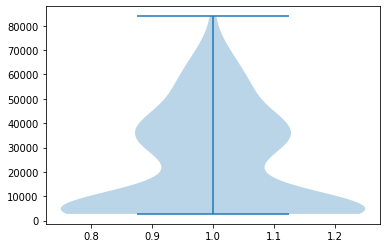

In [23]:
plt.violinplot(finals[:,0])

{'bodies': [<matplotlib.collections.PolyCollection at 0x1a2c7c8ff88>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1a2c7c9f108>,
 'cmins': <matplotlib.collections.LineCollection at 0x1a2c7cc8988>,
 'cbars': <matplotlib.collections.LineCollection at 0x1a2c7cc8908>}

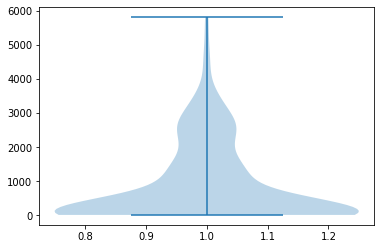

In [24]:
plt.violinplot(finals[:,1])

In [25]:
ci_0 = sorted(finals[:,0])
print(ci_0[4], ci_0[-5])

3080.8411608009587 69014.14366878037


In [26]:
ci_1 = sorted(finals[:,1])
print(ci_1[4], ci_1[-5])

27.038992587640497 3788.4422940895465


# do GP reg

In [28]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

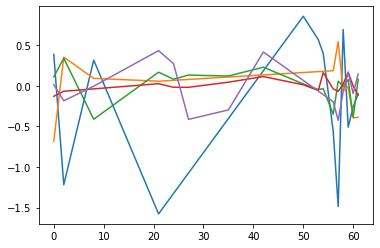

In [29]:
gps = []
for obs, i, cm in zip(objective.observations, config['observation_vector'], objective.collocation_matrices):
    cmfilter = np.diag(cm) == 1
    comp = ca.interp1d(model.observation_times,xref[i],objective.observation_times).toarray().flatten()[cmfilter]
    delta = (np.log(obs[cmfilter]+1) - np.log(comp+1)).reshape(-1,1)
    gptime = data_time[cmfilter].reshape(-1,1)
    plt.plot(gptime, delta)
    gp = gaussian_process.GaussianProcessRegressor(alpha=0.35, kernel=kernel)
    gp.fit(gptime, delta)
    gps.append((gp, gptime, comp, cmfilter))
    

In [30]:
def resample_gp(gps):
    out = []
    for gp, t, x, c in gps:
        temp = np.empty((len(c)))
        temp[:] = np.nan
        y = gp.sample_y(t, random_state=None).flatten()
        temp[c] = np.exp(y+np.log(x+1)).flatten() - 1
        out.append(temp)
    return out

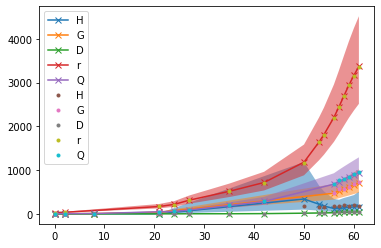

In [31]:
plt.figure()
def GP2Y(x, y):
    return np.exp(y+np.log(x+1)).flatten() - 1
for gp, t, x, c in gps:
    y,s = gp.predict(t, return_std=True)
    y=y.flatten(); s=s.flatten()
    temp = GP2Y(x, y)
    plt.plot(data_time[c], temp, 'x-')
    plt.fill(np.concatenate([data_time[c], data_time[c][::-1]]),
             np.concatenate([GP2Y(x, y - 2*s),
                             GP2Y(x, (y + 2*s))[::-1]]),
         alpha=.5, label='95% CI')
plt.plot(data_time, data_pd, '.')
plt.legend('HGDrQHGDrQ')

In [32]:
yg = [resample_gp(gps) for _ in range(500)]

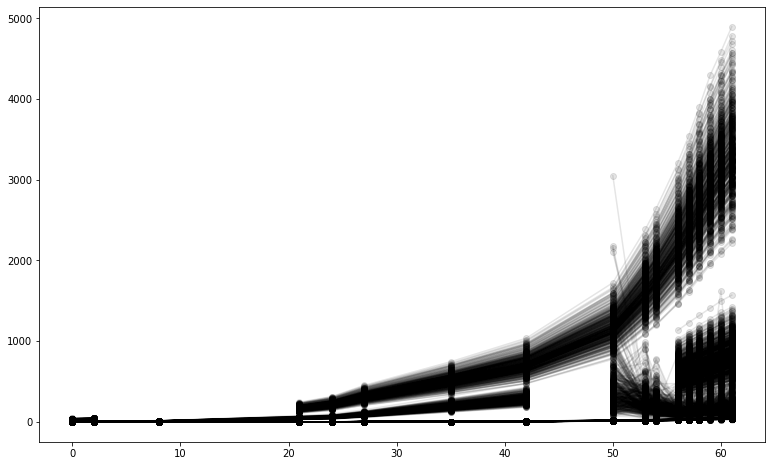

In [33]:
plt.figure(figsize=[13,8])
for y in yg:
    for x in y:
        plt.plot(objective.observation_times, x, 'ko-', alpha=0.1)

In [34]:
gpresolves = []
for y in yg:
    # construct problem
    dpd = np.vstack(y).T
    objective.observations = objective.observations_from_pandas(dpd)
    objective.create_objective(model)
    isetup = {
        'f': objective.objective,
        'x': ca.vcat(objective.input_list),
        'p': ca.hcat([objective.rho, objective.alpha]),
        'g': ca.vcat(model.xs),
    }
    isolver = ca.nlpsol('solver', 'ipopt', isetup, ipopt_opts)
    isolve_opts = {
        'x0': solref,
        'p': [rho, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    gpresolves.append(isolver(**isolve_opts))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

 900 1.7446146e+003 0.00e+000 1.45e+000  -5.7 3.91e+002  -9.9 1.00e+000 1.00e+000f  1
 950 1.7437110e+003 0.00e+000 1.39e-001  -5.7 1.27e+000  -5.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000 1.7421464e+003 0.00e+000 1.73e+001  -5.7 1.04e+003  -9.8 1.00e+000 5.00e-001f  2
1050 1.7387722e+003 0.00e+000 1.64e+000  -5.7 1.53e+002  -8.4 1.00e+000 1.00e+000f  1
1100 1.7364701e+003 0.00e+000 8.54e-001  -5.7 3.49e+003 -12.1 1.00e+000 2.50e-001f  3

Number of Iterations....: 1144

                                   (scaled)                 (unscaled)
Objective...............:  3.7887948123983796e+002   1.7364075379945227e+003
Dual infeasibility......:  1.1726724031006582e-010   5.3743665233039032e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  7.1450753616499361e-009   3.2745934609359777e-008
Overall NLP error.......:  7.1450753616499361e-009   3.2745934609359777e-008


 150 1.5919223e+003 0.00e+000 7.28e-001  -3.8 9.03e+000  -6.5 1.00e+000 1.00e+000f  1

Number of Iterations....: 170

                                   (scaled)                 (unscaled)
Objective...............:  1.5075758373030756e+003   1.5915537912981904e+003
Dual infeasibility......:  7.8300397429004179e-009   8.2662040147326822e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.2067060421886827e-009   1.2739243551843533e-009
Overall NLP error.......:  7.8300397429004179e-009   8.2662040147326822e-009


Number of objective function evaluations             = 261
Number of objective gradient evaluations             = 171
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 261
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 171
Number of Lagrangian Hessian evaluations             = 170
Total CPU secs 

  50 1.2313418e+003 0.00e+000 1.56e+002  -2.5 1.97e+001  -4.5 1.00e+000 1.00e+000f  1
 100 1.2269561e+003 0.00e+000 3.19e-001  -5.7 1.29e+003 -11.4 1.00e+000 1.00e+000f  1
 150 1.2262680e+003 0.00e+000 2.12e-008  -8.6 6.30e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 151

                                   (scaled)                 (unscaled)
Objective...............:  9.4149783369130978e+002   1.2262679938729591e+003
Dual infeasibility......:  5.4031426865503225e-009   7.0374043420452450e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.1397983578217744e-009   1.4845474898076780e-009
Overall NLP error.......:  5.4031426865503225e-009   7.0374043420452450e-009


Number of objective function evaluations             = 312
Number of objective gradient evaluations             = 152
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 312
Number of equality

  50 1.0671820e+004 0.00e+000 6.44e+001  -1.7 1.32e+002  -6.5 1.00e+000 1.00e+000f  1
 100 1.0639585e+004 0.00e+000 1.25e-002  -3.8 4.63e+000  -6.3 1.00e+000 1.00e+000f  1

Number of Iterations....: 144

                                   (scaled)                 (unscaled)
Objective...............:  8.8519076587265263e+003   1.0611338371786251e+004
Dual infeasibility......:  7.0872520105444105e-010   8.4959346741342423e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5140495848596483e-009   3.0137493359518854e-009
Overall NLP error.......:  2.5140495848596483e-009   3.0137493359518854e-009


Number of objective function evaluations             = 219
Number of objective gradient evaluations             = 145
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 219
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

  50 1.6982589e+003 0.00e+000 1.29e+001  -2.5 1.60e+004    -  1.00e+000 5.00e-001f  2
 100 1.6962458e+003 0.00e+000 7.13e-001  -5.7 5.17e+002  -9.6 1.00e+000 1.00e+000f  1
 150 1.6933449e+003 0.00e+000 2.43e+001  -5.7 1.57e+003  -9.1 1.00e+000 2.50e-001f  3

Number of Iterations....: 186

                                   (scaled)                 (unscaled)
Objective...............:  6.0327576030474211e+002   1.6889939825776601e+003
Dual infeasibility......:  6.8738652260440555e-009   1.9244792792558976e-008
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6153177866940655e-009   7.3221175039806731e-009
Overall NLP error.......:  6.8738652260440555e-009   1.9244792792558976e-008


Number of objective function evaluations             = 271
Number of objective gradient evaluations             = 187
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 271
Number of equality

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

1000 1.9749609e+003 0.00e+000 4.55e-001  -5.7 2.69e+001  -8.1 1.00e+000 1.00e+000f  1
1050 1.9735711e+003 0.00e+000 1.14e+001  -5.7 8.47e+002  -9.4 1.00e+000 1.00e+000f  1
1100 1.9705879e+003 0.00e+000 2.07e+001  -5.7 2.07e+004    -  1.00e+000 2.28e-002f  4

Number of Iterations....: 1137

                                   (scaled)                 (unscaled)
Objective...............:  1.0428973889196959e+003   1.9699923168251173e+003
Dual infeasibility......:  1.1724328325077724e-010   2.2146796957909244e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  4.3416108517137231e-009   8.2011328356860749e-009
Overall NLP error.......:  4.3416108517137231e-009   8.2011328356860749e-009


Number of objective function evaluations             = 1928
Number of objective gradient evaluations             = 1138
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1928
Number of equa

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4


Number of Iterations....: 143

                                   (scaled)                 (unscaled)
Objective...............:  2.2419599826644871e+003   2.2419599826644871e+003
Dual infeasibility......:  3.8610481577921963e-009   3.8610481577921963e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.0471357222722158e-009   1.0471357222722158e-009
Overall NLP error.......:  3.8610481577921963e-009   3.8610481577921963e-009


Number of objective function evaluations             = 252
Number of objective gradient evaluations             = 144
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 252
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 144
Number of Lagrangian Hessian evaluations             = 143
Total CPU secs in IPOPT (w/o function evaluations)   =      1.541
Total CPU secs in NLP function eval

  50 1.1352559e+004 0.00e+000 3.61e+001  -1.7 1.66e+001  -5.2 1.00e+000 1.00e+000f  1
 100 1.1317753e+004 0.00e+000 1.72e+000  -2.5 4.93e+000  -5.1 1.00e+000 1.00e+000f  1

Number of Iterations....: 149

                                   (scaled)                 (unscaled)
Objective...............:  4.5855299890472124e+003   1.1308873822973110e+004
Dual infeasibility......:  3.3305545563334428e-010   8.2138425281412533e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.5082070363568486e-009   3.7195532716652804e-009
Overall NLP error.......:  1.5082070363568486e-009   3.7195532716652804e-009


Number of objective function evaluations             = 253
Number of objective gradient evaluations             = 150
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 253
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 9.9663156e+002 0.00e+000 1.01e+001  -1.7 3.43e+000  -5.2 1.00e+000 1.00e+000f  1
 100 9.7870092e+002 0.00e+000 2.23e+000  -5.7 1.56e+003 -11.6 1.00e+000 1.00e+000f  1
 150 9.7791620e+002 0.00e+000 9.60e+000  -5.7 1.39e+001  -7.0 1.00e+000 1.00e+000f  1

Number of Iterations....: 181

                                   (scaled)                 (unscaled)
Objective...............:  9.7666226585447873e+002   9.7666226585447873e+002
Dual infeasibility......:  4.1010425349229932e-009   4.1010425349229932e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6077476874908201e-009   2.6077476874908201e-009
Overall NLP error.......:  4.1010425349229932e-009   4.1010425349229932e-009


Number of objective function evaluations             = 372
Number of objective gradient evaluations             = 182
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 372
Number of equality


Number of Iterations....: 47

                                   (scaled)                 (unscaled)
Objective...............:  1.6455835091493855e+003   2.9232285994804251e+003
Dual infeasibility......:  8.2437898767156748e-010   1.4644338741689964e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.6565407715453270e-009   1.7153961496625277e-008
Overall NLP error.......:  9.6565407715453270e-009   1.7153961496625277e-008


Number of objective function evaluations             = 73
Number of objective gradient evaluations             = 48
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 73
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 48
Number of Lagrangian Hessian evaluations             = 47
Total CPU secs in IPOPT (w/o function evaluations)   =      0.487
Total CPU secs in NLP function evaluation

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2


Number of Iterations....: 36

                                   (scaled)                 (unscaled)
Objective...............:  7.7607469149751807e+002   7.7607469149751807e+002
Dual infeasibility......:  5.1064421222286755e-009   5.1064421222286755e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.1352020090753618e-009   1.1352020090753618e-009
Overall NLP error.......:  5.1064421222286755e-009   5.1064421222286755e-009


Number of objective function evaluations             = 47
Number of objective gradient evaluations             = 37
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 47
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 37
Number of Lagrangian Hessian evaluations             = 36
Total CPU secs in IPOPT (w/o function evaluations)   =      0.298
Total CPU secs in NLP function evaluation

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

  50 2.2358629e+003 0.00e+000 8.55e+001  -3.8 2.31e+002  -7.5 1.00e+000 1.00e+000f  1
 100 2.2193758e+003 0.00e+000 7.35e-001  -3.8 4.01e+001  -6.9 1.00e+000 1.00e+000f  1
 150 2.2161648e+003 0.00e+000 8.52e-001  -3.8 6.83e+001  -8.0 1.00e+000 1.00e+000f  1

Number of Iterations....: 179

                                   (scaled)                 (unscaled)
Objective...............:  9.5410884646199986e+002   2.2143950856873066e+003
Dual infeasibility......:  3.8999404553410194e-009   9.0513875967129751e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6537261422577397e-009   6.1590437505806293e-009
Overall NLP error.......:  3.8999404553410194e-009   9.0513875967129751e-009


Number of objective function evaluations             = 254
Number of objective gradient evaluations             = 180
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 254
Number of equality

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2


Number of Iterations....: 37

                                   (scaled)                 (unscaled)
Objective...............:  4.7834648243554266e+003   8.5230537572355970e+003
Dual infeasibility......:  3.0796747726136057e-011   5.4872847623218458e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5216868466645216e-009   4.4930763248440434e-009
Overall NLP error.......:  2.5216868466645216e-009   4.4930763248440434e-009


Number of objective function evaluations             = 55
Number of objective gradient evaluations             = 38
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 55
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 38
Number of Lagrangian Hessian evaluations             = 37
Total CPU secs in IPOPT (w/o function evaluations)   =      0.454
Total CPU secs in NLP function evaluation

  50 2.2216744e+003 0.00e+000 1.02e+001  -2.5 2.67e+001  -6.1 1.00e+000 1.00e+000f  1
 100 2.2043148e+003 0.00e+000 1.38e+000  -3.8 1.14e+003 -10.8 1.00e+000 1.00e+000f  1
 150 2.2031771e+003 0.00e+000 1.70e+000  -3.8 1.12e+001  -7.6 1.00e+000 5.00e-001f  2
 200 2.2001665e+003 0.00e+000 1.58e-002  -5.7 1.17e+001    -  1.00e+000 9.87e-001f  1

Number of Iterations....: 209

                                   (scaled)                 (unscaled)
Objective...............:  7.4129225593907984e+002   2.2001650534033633e+003
Dual infeasibility......:  6.1467802252600873e-009   1.8243723624814865e-008
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.1438101262313837e-009   3.3948433256936580e-009
Overall NLP error.......:  6.1467802252600873e-009   1.8243723624814865e-008


Number of objective function evaluations             = 331
Number of objective gradient evaluations             = 210
Number of equality constraint evaluations       

  50 6.1977825e+003 0.00e+000 4.23e+000  -3.8 3.97e+003 -10.7 1.00e+000 5.00e-001f  2
 100 6.1945374e+003 0.00e+000 2.44e+000  -3.8 2.90e+000  -5.1 1.00e+000 1.00e+000f  1

Number of Iterations....: 123

                                   (scaled)                 (unscaled)
Objective...............:  3.9918426645279055e+003   6.1937803337952901e+003
Dual infeasibility......:  5.7654209309811888e-009   8.9456809246729733e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6084500816616259e-009   4.0472954911396049e-009
Overall NLP error.......:  5.7654209309811888e-009   8.9456809246729733e-009


Number of objective function evaluations             = 198
Number of objective gradient evaluations             = 124
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 198
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 1.3725040e+003 0.00e+000 4.57e+001  -1.0 3.43e+001  -5.7 1.00e+000 1.00e+000f  1
 100 1.3765243e+003 0.00e+000 1.59e+003  -1.0 1.71e+004    -  5.03e-001 5.24e-002f  4
 150 1.3746272e+003 0.00e+000 2.99e+001  -1.0 4.51e+001  -7.1 1.00e+000 1.00e+000f  1
 200 1.3758300e+003 0.00e+000 2.82e+002  -1.0 1.26e+002  -8.4 1.00e+000 1.00e+000f  1
 250 1.3467179e+003 0.00e+000 3.27e+003  -2.5 2.35e+003  -8.1 1.00e+000 1.25e-001f  4
 300 1.3416150e+003 0.00e+000 1.56e+002  -2.5 4.69e+001  -7.6 1.00e+000 1.00e+000f  1
 350 1.3346336e+003 0.00e+000 8.37e+001  -2.5 5.56e+001  -7.4 1.00e+000 1.00e+000f  1
 400 1.3263380e+003 0.00e+000 8.94e+002  -2.5 1.51e+002  -7.3 1.00e+000 2.50e-001f  3
 450 1.3204617e+003 0.00e+000 2.09e+001  -2.5 3.44e+001  -7.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.3179499e+003 0.00e+000 5.27e+002  -2.5 5.17e+004    -  4.52e-001 3.01e-003f  7
 550 1.3164758e+003 0.00e+000 2.48e+000  -2.5 6.85e+000  -6

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

 100 1.3097719e+003 0.00e+000 7.69e-003  -8.6 7.35e+000    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 103

                                   (scaled)                 (unscaled)
Objective...............:  5.8536359808971736e+002   1.3097713701656910e+003
Dual infeasibility......:  1.3702473046847517e-012   3.0659759089558573e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5068085384015422e-009   5.6090711222907476e-009
Overall NLP error.......:  2.5068085384015422e-009   5.6090711222907476e-009


Number of objective function evaluations             = 190
Number of objective gradient evaluations             = 104
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 190
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 104
Number of Lagrangian Hessian evaluations             = 103
Total CPU secs 

 100 9.3307555e+003 0.00e+000 4.97e+002  -1.0 1.69e+004    -  1.24e-001 3.37e-002f  5
 150 9.2909977e+003 0.00e+000 2.63e+000  -2.5 2.03e+000  -4.9 1.00e+000 1.00e+000f  1
 200 9.2668814e+003 0.00e+000 4.28e-001  -3.8 1.17e+000  -4.4 1.00e+000 1.00e+000f  1
 250 9.2532360e+003 0.00e+000 9.86e+000  -3.8 8.34e+002 -10.0 1.00e+000 1.00e+000f  1

Number of Iterations....: 278

                                   (scaled)                 (unscaled)
Objective...............:  6.5236158032575622e+003   9.2529396964556508e+003
Dual infeasibility......:  8.7080731572519705e-010   1.2351321449086786e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5715772798091531e-009   3.6474633412604886e-009
Overall NLP error.......:  2.5715772798091531e-009   3.6474633412604886e-009


Number of objective function evaluations             = 436
Number of objective gradient evaluations             = 279
Number of equality constraint evaluations       

  50 3.3876371e+003 0.00e+000 1.70e+002  -1.0 1.79e+002  -6.2 1.00e+000 1.00e+000f  1
 100 3.3523547e+003 0.00e+000 6.89e+000  -2.5 2.29e+001  -6.0 1.00e+000 1.00e+000f  1
 150 3.3386363e+003 0.00e+000 2.80e+001  -2.5 5.75e+001  -6.4 1.00e+000 1.00e+000f  1
 200 3.3189391e+003 0.00e+000 1.12e+000  -2.5 4.65e+000  -5.7 1.00e+000 1.00e+000f  1
 250 3.3008557e+003 0.00e+000 2.71e-001  -3.8 4.79e+000  -5.9 1.00e+000 1.00e+000f  1
 300 3.3001217e+003 0.00e+000 1.91e+001  -5.7 1.84e+005    -  1.05e-001 5.10e-003f  3

Number of Iterations....: 339

                                   (scaled)                 (unscaled)
Objective...............:  1.5510884526873310e+003   3.2992501761960166e+003
Dual infeasibility......:  9.1780016488240561e-010   1.9522112684513718e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.2763386761198117e-010   1.9731280932829932e-009
Overall NLP error.......:  9.2763386761198117e-010   1.9731280932829932e-

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

  50 1.9783114e+003 0.00e+000 7.21e+000  -1.7 4.34e+000  -6.2 1.00e+000 1.00e+000f  1
 100 1.9806336e+003 0.00e+000 2.55e+002  -2.5 1.89e+002  -7.1 1.00e+000 5.00e-001f  2
 150 1.9753296e+003 0.00e+000 2.92e+001  -2.5 1.72e+001  -6.6 1.00e+000 1.00e+000f  1
 200 1.9700523e+003 0.00e+000 5.57e+000  -5.7 2.32e+004    -  1.00e+000 2.31e-001f  3

Number of Iterations....: 214

                                   (scaled)                 (unscaled)
Objective...............:  1.9700481605404489e+003   1.9700481605404489e+003
Dual infeasibility......:  5.0025957568126351e-009   5.0025957568126351e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.1894437734882564e-009   1.1894437734882564e-009
Overall NLP error.......:  5.0025957568126351e-009   5.0025957568126351e-009


Number of objective function evaluations             = 455
Number of objective gradient evaluations             = 215
Number of equality constraint evaluations       

 100 8.5568741e+002 0.00e+000 2.21e-001  -5.7 2.94e+003    -  1.00e+000 5.00e-001f  2

Number of Iterations....: 144

                                   (scaled)                 (unscaled)
Objective...............:  3.6415235525819958e+002   8.5538820799705979e+002
Dual infeasibility......:  6.6669913320239897e-010   1.5660658748694226e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.8731905704486263e-009   6.7490798776997909e-009
Overall NLP error.......:  2.8731905704486263e-009   6.7490798776997909e-009


Number of objective function evaluations             = 316
Number of objective gradient evaluations             = 145
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 316
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 145
Number of Lagrangian Hessian evaluations             = 144
Total CPU secs 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

  50 7.4927133e+002 0.00e+000 5.13e+001  -1.0 4.55e+001  -5.9 1.00e+000 1.00e+000f  1
 100 7.5272497e+002 0.00e+000 4.21e+002  -1.0 3.42e+002  -7.6 1.00e+000 1.00e+000f  1
 150 7.5223661e+002 0.00e+000 1.02e+004  -1.0 1.27e+004    -  1.00e+000 6.25e-002f  5
 200 7.0805548e+002 0.00e+000 1.83e+003  -3.8 6.50e+002  -8.9 1.00e+000 5.00e-001f  2
 250 7.0458070e+002 0.00e+000 4.19e+002  -3.8 8.60e+001  -7.5 1.00e+000 1.00e+000f  1
 300 6.9988973e+002 0.00e+000 6.63e+001  -3.8 9.26e+001  -7.9 1.00e+000 1.00e+000f  1
 350 6.9540990e+002 0.00e+000 1.52e+003  -3.8 1.02e+003  -8.3 1.00e+000 6.25e-002f  5
 400 6.9173390e+002 0.00e+000 7.79e+001  -3.8 8.28e+001  -7.7 1.00e+000 1.00e+000f  1
 450 6.8959268e+002 0.00e+000 8.12e-001  -3.8 3.77e+000  -6.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 6.8760867e+002 0.00e+000 7.31e+000  -3.8 1.17e+001  -6.7 1.00e+000 1.00e+000f  1
 550 6.8547073e+002 0.00e+000 6.68e+001  -3.8 3.63e+001  -7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1


Number of Iterations....: 76

                                   (scaled)                 (unscaled)
Objective...............:  1.4416425167994355e+003   1.4416425167994355e+003
Dual infeasibility......:  1.8523258974771187e-009   1.8523258974771187e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.0318965755985740e-009   1.0318965755985740e-009
Overall NLP error.......:  1.8523258974771187e-009   1.8523258974771187e-009


Number of objective function evaluations             = 147
Number of objective gradient evaluations             = 77
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 147
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 77
Number of Lagrangian Hessian evaluations             = 76
Total CPU secs in IPOPT (w/o function evaluations)   =      0.744
Total CPU secs in NLP function evaluati

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

 100 2.1156483e+003 0.00e+000 5.64e+000  -1.0 9.40e+000  -5.4 1.00e+000 1.00e+000f  1
 150 2.1231819e+003 0.00e+000 7.30e+002  -1.0 2.37e+002  -7.2 1.00e+000 1.00e+000f  1
 200 2.1182384e+003 0.00e+000 1.26e+003  -1.7 2.04e+002  -6.7 8.52e-001 1.00e+000f  1
 250 2.0991787e+003 0.00e+000 4.84e+003  -1.7 3.22e+002  -8.4 1.00e+000 5.00e-001f  2
 300 2.0910053e+003 0.00e+000 7.20e+002  -1.7 2.76e+003    -  1.00e+000 2.50e-001f  3
 350 2.0883454e+003 0.00e+000 2.78e-002  -2.5 1.95e-001  -6.2 1.00e+000 1.00e+000f  1
 400 2.0878704e+003 0.00e+000 2.05e+002  -5.7 3.79e+003    -  1.00e+000 1.01e-001f  1

Number of Iterations....: 409

                                   (scaled)                 (unscaled)
Objective...............:  1.3810585834494789e+003   2.0878689418601457e+003
Dual infeasibility......:  6.1244001749911083e-009   9.2587997830973561e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059111930792053e-009   3.788408553

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

  50 3.1391383e+003 0.00e+000 4.99e+000  -5.7 6.60e+000  -7.3 1.00e+000 1.00e+000f  1
 100 3.1365534e+003 0.00e+000 1.47e+001  -5.7 3.93e+002  -8.6 1.00e+000 2.50e-001f  3
 150 3.1313274e+003 0.00e+000 1.01e-007  -8.6 1.70e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 151

                                   (scaled)                 (unscaled)
Objective...............:  1.6489844760284611e+003   3.1313274114294063e+003
Dual infeasibility......:  6.7540892000300374e-009   1.2825629930871669e-008
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6118446804408253e-009   4.9597439885900267e-009
Overall NLP error.......:  6.7540892000300374e-009   1.2825629930871669e-008


Number of objective function evaluations             = 197
Number of objective gradient evaluations             = 152
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 197
Number of equality

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

  50 9.0264370e+002 0.00e+000 3.32e+001  -2.5 7.20e+000  -4.9 1.00e+000 1.00e+000f  1
 100 9.0067897e+002 0.00e+000 3.70e-003  -3.8 9.87e-001  -7.0 1.00e+000 1.00e+000f  1
 150 9.0044286e+002 0.00e+000 1.78e+001  -5.7 6.21e+004    -  1.00e+000 3.79e-002f  4
 200 9.0029581e+002 0.00e+000 2.20e+001  -5.7 1.95e+004    -  1.00e+000 3.12e-002f  6
 250 9.0024481e+002 0.00e+000 7.04e-001  -5.7 8.97e+001 -10.4 1.00e+000 1.00e+000f  1
 300 9.0021754e+002 0.00e+000 1.20e+001  -5.7 6.60e+003    -  1.00e+000 1.25e-001f  4
 350 9.0020209e+002 0.00e+000 8.98e-002  -5.7 5.05e+001    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 358

                                   (scaled)                 (unscaled)
Objective...............:  2.8975867617809490e+002   9.0020178853291986e+002
Dual infeasibility......:  1.6124667182338596e-010   5.0094977063318796e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059036697944115e-009   7.785164521

  50 1.9326334e+003 0.00e+000 1.83e+000  -1.7 1.12e+001  -6.7 1.00e+000 1.00e+000f  1
 100 1.9311275e+003 0.00e+000 1.62e+001  -3.8 4.47e+000  -4.6 1.00e+000 1.00e+000f  1
 150 1.9253538e+003 0.00e+000 1.87e+000  -3.8 1.02e+001  -6.3 1.00e+000 1.00e+000f  1
 200 1.9236665e+003 0.00e+000 5.65e-001  -3.8 1.53e+002  -9.2 1.00e+000 1.00e+000f  1

Number of Iterations....: 240

                                   (scaled)                 (unscaled)
Objective...............:  1.9231292708966400e+003   1.9231292708966400e+003
Dual infeasibility......:  6.6989941189543763e-011   6.6989941189543763e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.1153244673305566e-010   9.1153244673305566e-010
Overall NLP error.......:  9.1153244673305566e-010   9.1153244673305566e-010


Number of objective function evaluations             = 429
Number of objective gradient evaluations             = 241
Number of equality constraint evaluations       

  50 3.3968268e+003 0.00e+000 4.49e-002  -8.6 1.93e+003    -  9.82e-001 8.88e-001f  1

Number of Iterations....: 54

                                   (scaled)                 (unscaled)
Objective...............:  1.9058512165459294e+003   3.3968267698365275e+003
Dual infeasibility......:  1.0375356035080432e-009   1.8492150289894809e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.4339810392856356e-009   2.5558055840850921e-009
Overall NLP error.......:  1.4339810392856356e-009   2.5558055840850921e-009


Number of objective function evaluations             = 83
Number of objective gradient evaluations             = 55
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 83
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 55
Number of Lagrangian Hessian evaluations             = 54
Total CPU secs in IPO

 150 1.2910452e+003 0.00e+000 6.19e+000  -5.7 1.73e+002  -8.5 1.00e+000 1.25e-001f  4

Number of Iterations....: 166

                                   (scaled)                 (unscaled)
Objective...............:  4.3987169780143608e+002   1.2909066276932999e+003
Dual infeasibility......:  7.6506709875416288e-009   2.2452687757548398e-008
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6844863916623799e-009   7.8782547098853704e-009
Overall NLP error.......:  7.6506709875416288e-009   2.2452687757548398e-008


Number of objective function evaluations             = 300
Number of objective gradient evaluations             = 167
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 300
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 167
Number of Lagrangian Hessian evaluations             = 166
Total CPU secs 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

  50 4.4980343e+003 0.00e+000 6.46e+001  -2.5 1.66e+004    -  4.86e-001 5.02e-002f  3
 100 4.4722102e+003 0.00e+000 9.17e-001  -3.8 6.34e+002 -10.6 1.00e+000 1.00e+000f  1
 150 4.4714920e+003 0.00e+000 1.22e-002  -8.6 1.66e+001    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 155

                                   (scaled)                 (unscaled)
Objective...............:  8.6598919160997491e+002   4.4714919266882844e+003
Dual infeasibility......:  1.6544508838009871e-009   8.5426744833442084e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5773382384281183e-009   1.3307957232180761e-008
Overall NLP error.......:  2.5773382384281183e-009   1.3307957232180761e-008


Number of objective function evaluations             = 320
Number of objective gradient evaluations             = 156
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 320
Number of equality

  50 1.3744266e+003 0.00e+000 4.92e+000  -2.5 2.82e+001  -6.2 1.00e+000 1.00e+000f  1
 100 1.3553770e+003 0.00e+000 9.50e+002  -2.5 1.31e+003  -7.5 1.00e+000 3.22e-001f  2
 150 1.3201246e+003 0.00e+000 2.94e-002  -5.7 1.66e+001  -9.0 1.00e+000 9.70e-001f  1

Number of Iterations....: 189

                                   (scaled)                 (unscaled)
Objective...............:  9.2637100800805285e+002   1.3177477041214584e+003
Dual infeasibility......:  1.3376575468188430e-009   1.9027961216225257e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  6.6834665355853637e-009   9.5071225315847218e-009
Overall NLP error.......:  6.6834665355853637e-009   9.5071225315847218e-009


Number of objective function evaluations             = 249
Number of objective gradient evaluations             = 190
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 249
Number of equality

  50 4.9886965e+002 0.00e+000 4.37e+000  -3.8 3.58e+004    -  1.00e+000 1.25e-001f  4
 100 4.9846894e+002 0.00e+000 3.94e-001  -3.8 3.59e+000  -6.6 1.00e+000 1.00e+000f  1

Number of Iterations....: 137

                                   (scaled)                 (unscaled)
Objective...............:  2.1762669017265745e+002   4.9783613625499771e+002
Dual infeasibility......:  5.8801567105064733e-010   1.3451265995958392e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5500034169338421e-009   5.8333095426678663e-009
Overall NLP error.......:  2.5500034169338421e-009   5.8333095426678663e-009


Number of objective function evaluations             = 284
Number of objective gradient evaluations             = 138
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 284
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 4.5789729e+003 0.00e+000 6.73e+001  -2.5 4.55e+005    -  2.75e-002 1.32e-003f  4

Number of Iterations....: 83

                                   (scaled)                 (unscaled)
Objective...............:  4.5756498880813215e+003   4.5756498880813215e+003
Dual infeasibility......:  1.1258602802988406e-009   1.1258602802988406e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  8.3122251665703981e-009   8.3122251665703981e-009
Overall NLP error.......:  8.3122251665703981e-009   8.3122251665703981e-009


Number of objective function evaluations             = 147
Number of objective gradient evaluations             = 84
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 147
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 84
Number of Lagrangian Hessian evaluations             = 83
Total CPU secs in I

  50 5.1921443e+003 0.00e+000 3.97e+002  -1.0 1.95e+004    -  3.81e-001 4.90e-002f  5
 100 5.1506546e+003 0.00e+000 2.05e+000  -2.5 1.16e+001  -5.8 1.00e+000 1.00e+000f  1
 150 5.1399017e+003 0.00e+000 3.65e+000  -3.8 2.51e+002  -8.0 1.00e+000 1.00e+000f  1
 200 5.1223473e+003 0.00e+000 7.27e+001  -3.8 2.18e+005    -  1.66e-001 2.06e-002f  3
 250 5.1193937e+003 0.00e+000 1.02e+001  -3.8 1.73e+003    -  1.00e+000 5.00e-001f  2
 300 5.1191124e+003 0.00e+000 2.73e-008  -9.0 1.33e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 301

                                   (scaled)                 (unscaled)
Objective...............:  2.6081109152884496e+003   5.1191123918006897e+003
Dual infeasibility......:  2.7285656774650653e-011   5.3555369480168965e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.1139607339738220e-010   1.7888575619304268e-009
Overall NLP error.......:  9.1139607339738220e-010   1.7888575619304268e-

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

  50 1.2646984e+004 0.00e+000 6.47e+001  -2.5 1.07e+004    -  1.00e+000 2.50e-001f  3
 100 1.2645673e+004 0.00e+000 1.87e+001  -3.8 2.63e+003 -10.4 1.00e+000 1.00e+000f  1
 150 1.2644378e+004 0.00e+000 5.77e-004  -5.7 1.77e+000    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 154

                                   (scaled)                 (unscaled)
Objective...............:  1.0334511051739506e+004   1.2644378156194378e+004
Dual infeasibility......:  4.8032887806222448e-011   5.8768721066267170e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.8884918278147418e-009   3.5340987869783260e-009
Overall NLP error.......:  2.8884918278147418e-009   3.5340987869783260e-009


Number of objective function evaluations             = 248
Number of objective gradient evaluations             = 155
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 248
Number of equality

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9

  50 3.7250444e+003 0.00e+000 9.04e-003  -5.7 5.20e+000  -7.6 1.00e+000 1.00e+000f  1
 100 3.7232627e+003 0.00e+000 4.54e-002  -5.7 2.71e+001  -7.9 1.00e+000 1.00e+000f  1

Number of Iterations....: 133

                                   (scaled)                 (unscaled)
Objective...............:  1.3581824866491968e+003   3.7221025029540438e+003
Dual infeasibility......:  3.6120527646795845e-009   9.8988396392777962e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6177255922033769e-009   7.1738835352127961e-009
Overall NLP error.......:  3.6120527646795845e-009   9.8988396392777962e-009


Number of objective function evaluations             = 201
Number of objective gradient evaluations             = 134
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 201
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

1500 9.3423955e+002 0.00e+000 3.12e+000  -5.7 1.77e+002  -8.0 1.00e+000 1.00e+000f  1

Number of Iterations....: 1548

                                   (scaled)                 (unscaled)
Objective...............:  3.8003008632037341e+002   9.3211902494389392e+002
Dual infeasibility......:  1.7770519144037907e-009   4.3586651619270514e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.1400599390033669e-009   2.7962827075368948e-009
Overall NLP error.......:  1.7770519144037907e-009   4.3586651619270514e-009


Number of objective function evaluations             = 2524
Number of objective gradient evaluations             = 1549
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 2524
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 1549
Number of Lagrangian Hessian evaluations             = 1548
Total CPU

  50 6.7987680e+003 0.00e+000 5.05e-001  -3.8 1.67e+003    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 73

                                   (scaled)                 (unscaled)
Objective...............:  1.2340027072307942e+003   6.7987007467827989e+003
Dual infeasibility......:  3.3176859870056042e-009   1.8278691015243627e-008
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.4022481679431995e-009   5.1801403081425470e-008
Overall NLP error.......:  9.4022481679431995e-009   5.1801403081425470e-008


Number of objective function evaluations             = 143
Number of objective gradient evaluations             = 74
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 143
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 74
Number of Lagrangian Hessian evaluations             = 73
Total CPU secs in I

  50 1.3893693e+003 0.00e+000 2.20e+002  -2.5 1.32e+002  -6.9 1.00e+000 1.00e+000f  1
 100 1.3828460e+003 0.00e+000 3.17e-003  -5.7 3.01e+001    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 105

                                   (scaled)                 (unscaled)
Objective...............:  1.3828457864399970e+003   1.3828457864399970e+003
Dual infeasibility......:  7.3351657900712708e-011   7.3351657900712708e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.5722981762631494e-009   9.5722981762631494e-009
Overall NLP error.......:  9.5722981762631494e-009   9.5722981762631494e-009


Number of objective function evaluations             = 193
Number of objective gradient evaluations             = 106
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 193
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1


Number of Iterations....: 136

                                   (scaled)                 (unscaled)
Objective...............:  2.7216792726676300e+002   4.8316385084068304e+002
Dual infeasibility......:  1.4707704497962766e-009   2.6109730171466586e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.0293648308970530e-009   1.8273713608022359e-009
Overall NLP error.......:  1.4707704497962766e-009   2.6109730171466586e-009


Number of objective function evaluations             = 243
Number of objective gradient evaluations             = 137
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 243
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 137
Number of Lagrangian Hessian evaluations             = 136
Total CPU secs in IPOPT (w/o function evaluations)   =      1.898
Total CPU secs in NLP function eval

  50 3.9152649e+003 0.00e+000 8.60e+001  -1.7 1.15e+001  -5.5 1.00e+000 1.00e+000f  1
 100 3.9156350e+003 0.00e+000 2.42e-001  -2.5 3.49e+000  -6.9 1.00e+000 1.00e+000f  1
 150 3.9102380e+003 0.00e+000 4.38e+000  -3.8 3.37e+002  -8.1 1.00e+000 1.00e+000f  1
 200 3.9002016e+003 0.00e+000 1.24e-001  -3.8 9.87e+000  -6.2 1.00e+000 1.00e+000f  1

Number of Iterations....: 231

                                   (scaled)                 (unscaled)
Objective...............:  2.9049924773523844e+003   3.8990836811847471e+003
Dual infeasibility......:  2.6517829238363440e-010   3.5592255763079030e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.7216399565155582e-009   2.3107867960620349e-009
Overall NLP error.......:  1.7216399565155582e-009   2.3107867960620349e-009


Number of objective function evaluations             = 416
Number of objective gradient evaluations             = 232
Number of equality constraint evaluations       

  50 1.8875132e+003 0.00e+000 2.29e+001  -1.0 2.70e+001  -5.6 1.00e+000 1.00e+000f  1
 100 1.8631907e+003 0.00e+000 1.03e+001  -1.7 3.19e+000  -4.9 1.00e+000 1.00e+000f  1
 150 1.8606521e+003 0.00e+000 1.50e+002  -2.5 5.28e+001  -6.0 1.00e+000 2.50e-001f  3
 200 1.8565541e+003 0.00e+000 3.41e+002  -2.5 9.10e+001  -7.1 1.00e+000 1.00e+000f  1
 250 1.8517086e+003 0.00e+000 7.77e-001  -2.5 6.66e+000  -5.7 1.00e+000 1.00e+000f  1
 300 1.8451760e+003 0.00e+000 5.32e+000  -3.8 2.10e+001  -6.1 1.00e+000 1.00e+000f  1
 350 1.8352906e+003 0.00e+000 9.07e+001  -3.8 1.22e+002  -6.5 1.00e+000 2.50e-001f  3
 400 1.8313673e+003 0.00e+000 1.46e-001  -3.8 5.65e+001  -7.7 1.00e+000 1.00e+000f  1
 450 1.8228645e+003 0.00e+000 7.57e-002  -3.8 9.40e+000  -6.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.8222335e+003 0.00e+000 2.66e-003  -3.8 3.14e+000  -7.4 1.00e+000 1.00e+000f  1
 550 1.8208923e+003 0.00e+000 6.55e-005  -8.6 6.55e-001    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

  50 1.8223341e+003 0.00e+000 2.15e+000  -1.7 1.11e+001  -5.9 1.00e+000 1.00e+000f  1
 100 1.8011159e+003 0.00e+000 8.63e-002  -3.8 4.27e+000  -5.6 1.00e+000 1.00e+000f  1

Number of Iterations....: 114

                                   (scaled)                 (unscaled)
Objective...............:  6.5876555947838517e+002   1.8010335984342637e+003
Dual infeasibility......:  1.1569572335779217e-009   3.1630658580198050e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5667074924480757e-009   7.0172557820300262e-009
Overall NLP error.......:  2.5667074924480757e-009   7.0172557820300262e-009


Number of objective function evaluations             = 218
Number of objective gradient evaluations             = 115
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 218
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 2.4870070e+003 0.00e+000 1.22e-003  -5.7 1.52e+000  -7.0 1.00e+000 1.00e+000f  1

Number of Iterations....: 62

                                   (scaled)                 (unscaled)
Objective...............:  1.9662344262506731e+003   2.4869974126286161e+003
Dual infeasibility......:  6.2634705788382076e-009   7.9223692331283387e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.1308237615022578e-009   1.4303257696274973e-009
Overall NLP error.......:  6.2634705788382076e-009   7.9223692331283387e-009


Number of objective function evaluations             = 107
Number of objective gradient evaluations             = 63
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 107
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 63
Number of Lagrangian Hessian evaluations             = 62
Total CPU secs in I

  50 7.7841388e+003 0.00e+000 8.97e+000  -1.0 3.43e+001    -  3.37e-002 2.64e-001f  1
 100 7.7382668e+003 0.00e+000 1.25e+002  -1.7 1.43e+004    -  1.00e+000 1.00e+000f  1
 150 7.7329486e+003 0.00e+000 2.44e+000  -5.7 6.22e+002  -9.1 1.00e+000 1.00e+000f  1
 200 7.7283916e+003 0.00e+000 6.99e+001  -5.7 1.34e+003    -  1.00e+000 2.74e-001f  1

Number of Iterations....: 214

                                   (scaled)                 (unscaled)
Objective...............:  7.7281664470941032e+003   7.7281664470941032e+003
Dual infeasibility......:  1.0124571567334805e-009   1.0124571567334805e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.2706988398185160e-010   9.2706988398185160e-010
Overall NLP error.......:  1.0124571567334805e-009   1.0124571567334805e-009


Number of objective function evaluations             = 296
Number of objective gradient evaluations             = 215
Number of equality constraint evaluations       

  50 3.1451603e+003 0.00e+000 2.97e+001  -3.8 2.66e+001  -6.5 1.00e+000 1.00e+000f  1
 100 3.1438450e+003 0.00e+000 4.68e+000  -3.8 9.58e+000  -6.9 1.00e+000 1.00e+000f  1
 150 3.1410899e+003 0.00e+000 4.29e-001  -3.8 7.20e+000  -6.4 1.00e+000 1.00e+000f  1

Number of Iterations....: 182

                                   (scaled)                 (unscaled)
Objective...............:  3.1392473616013745e+003   3.1392473616013745e+003
Dual infeasibility......:  8.4769757173356998e-010   8.4769757173356998e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5917682829571978e-009   2.5917682829571978e-009
Overall NLP error.......:  2.5917682829571978e-009   2.5917682829571978e-009


Number of objective function evaluations             = 238
Number of objective gradient evaluations             = 183
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 238
Number of equality

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

2500 4.7425516e+003 0.00e+000 1.39e+001  -5.7 5.29e+001    -  1.00e+000 5.00e-001h  2
2550 4.7425505e+003 0.00e+000 2.12e+001  -5.7 7.48e+001    -  1.00e+000 5.00e-001h  2
2600 4.7425488e+003 0.00e+000 7.96e-001  -5.7 7.59e+000    -  1.00e+000 1.00e+000h  1
2650 4.7425476e+003 0.00e+000 2.82e+002  -5.7 5.53e+002    -  1.00e+000 3.12e-002h  6
2700 4.7425466e+003 0.00e+000 1.25e+001  -5.7 4.74e+001    -  1.00e+000 5.00e-001h  2
2750 4.7425455e+003 0.00e+000 3.33e+000  -5.7 1.70e+001    -  1.00e+000 1.00e+000h  1
2800 4.7425447e+003 0.00e+000 1.09e+001  -5.7 3.19e+001    -  1.00e+000 1.00e+000h  1
2850 4.7425438e+003 0.00e+000 5.55e-001  -5.7 7.45e+000    -  1.00e+000 1.00e+000h  1
2900 4.7425430e+003 0.00e+000 3.66e+000  -5.7 1.96e+001    -  1.00e+000 1.00e+000h  1
2950 4.7425424e+003 0.00e+000 2.42e+001  -5.7 9.20e+001    -  1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000 4.7425417e+003 0.00e+000 1.67e-001  -5.7 4.53e+000    

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

  50 7.5597343e+002 0.00e+000 1.05e+001  -2.5 5.64e+000  -4.3 1.00e+000 1.00e+000f  1
 100 7.4639143e+002 0.00e+000 3.52e-002  -3.8 2.14e+000  -7.0 1.00e+000 1.00e+000f  1

Number of Iterations....: 124

                                   (scaled)                 (unscaled)
Objective...............:  7.4637315521183905e+002   7.4637315521183905e+002
Dual infeasibility......:  6.9033640197495568e-009   6.9033640197495568e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.3816814556588749e-009   1.3816814556588749e-009
Overall NLP error.......:  6.9033640197495568e-009   6.9033640197495568e-009


Number of objective function evaluations             = 213
Number of objective gradient evaluations             = 125
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 213
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 1.2585214e+003 0.00e+000 7.53e+000  -5.7 2.24e+002  -7.5 9.94e-001 3.43e-002f  5
 100 1.2569288e+003 0.00e+000 2.35e-003  -5.7 1.40e+001  -7.7 1.00e+000 1.00e+000f  1

Number of Iterations....: 145

                                   (scaled)                 (unscaled)
Objective...............:  4.9151696155717917e+002   1.2529767642547704e+003
Dual infeasibility......:  7.0458150557226601e-009   1.7961216479870992e-008
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6359210663406793e-009   6.7194992377700742e-009
Overall NLP error.......:  7.0458150557226601e-009   1.7961216479870992e-008


Number of objective function evaluations             = 209
Number of objective gradient evaluations             = 146
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 209
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 2.6911526e+003 0.00e+000 2.04e+001  -2.5 8.43e+000  -5.6 1.00e+000 1.00e+000f  1

Number of Iterations....: 82

                                   (scaled)                 (unscaled)
Objective...............:  2.2651895012993477e+003   2.6907932026515014e+003
Dual infeasibility......:  5.0607965502964304e-012   6.0116634611490830e-012
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.0874970186569052e-009   1.2918255112992724e-009
Overall NLP error.......:  1.0874970186569052e-009   1.2918255112992724e-009


Number of objective function evaluations             = 143
Number of objective gradient evaluations             = 83
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 143
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 83
Number of Lagrangian Hessian evaluations             = 82
Total CPU secs in I

  50 1.3687471e+003 0.00e+000 4.32e+002  -1.0 5.12e+001  -5.7 1.00e+000 1.00e+000f  1
 100 1.3995007e+003 0.00e+000 5.85e+002  -1.0 1.50e+002  -6.2 1.00e+000 5.00e-001f  2
 150 1.4254152e+003 0.00e+000 1.57e+002  -1.0 3.94e+001  -6.9 1.00e+000 1.00e+000f  1
 200 1.4469115e+003 0.00e+000 3.42e+004  -1.0 6.33e+003    -  1.00e+000 2.50e-001f  3
 250 1.4146985e+003 0.00e+000 3.92e+004  -2.5 1.61e+003  -8.9 1.00e+000 1.00e+000f  1
 300 1.3983228e+003 0.00e+000 4.04e+000  -2.5 1.22e+001  -6.4 1.00e+000 1.00e+000f  1
 350 1.3820390e+003 0.00e+000 1.03e+004  -2.5 5.01e+002  -8.8 1.00e+000 1.00e+000f  1
 400 1.3449912e+003 0.00e+000 1.10e+003  -2.5 1.02e+004    -  1.00e+000 1.00e+000f  1
 450 1.3315130e+003 0.00e+000 5.60e+000  -3.8 8.07e+002  -9.5 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 472

                                   (scaled)                 (unscaled)
Objective...............:  1.0588363575515


Number of Iterations....: 27

                                   (scaled)                 (unscaled)
Objective...............:  5.2577210854364948e+003   5.2577210854364948e+003
Dual infeasibility......:  5.5349408930294042e-011   5.5349408930294042e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  8.1477473985576585e-009   8.1477473985576585e-009
Overall NLP error.......:  8.1477473985576585e-009   8.1477473985576585e-009


Number of objective function evaluations             = 32
Number of objective gradient evaluations             = 28
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 32
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 28
Number of Lagrangian Hessian evaluations             = 27
Total CPU secs in IPOPT (w/o function evaluations)   =      0.252
Total CPU secs in NLP function evaluation

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

  50 2.9087812e+003 0.00e+000 4.35e+003  -1.0 1.32e+004    -  4.97e-001 1.19e-001f  4
 100 2.8826690e+003 0.00e+000 1.27e+002  -1.0 2.20e+002  -7.9 1.00e+000 1.00e+000f  1
 150 2.8841975e+003 0.00e+000 2.72e+003  -1.0 8.22e+002    -  1.00e+000 5.00e-001f  2
 200 2.8133564e+003 0.00e+000 4.19e+002  -2.5 5.45e+003    -  1.00e+000 3.12e-002f  6
 250 2.8129847e+003 0.00e+000 6.89e+002  -2.5 3.82e+002  -9.5 1.00e+000 5.00e-001f  2
 300 2.8121768e+003 0.00e+000 7.83e+001  -2.5 1.22e+002  -8.9 1.00e+000 1.00e+000f  1
 350 2.8104087e+003 0.00e+000 1.82e+003  -2.5 2.53e+002  -8.7 1.00e+000 1.00e+000f  1
 400 2.8063791e+003 0.00e+000 5.75e+002  -2.5 4.40e+002  -8.6 1.00e+000 2.50e-001f  3
 450 2.7994454e+003 0.00e+000 1.78e+003  -2.5 2.67e+002  -8.4 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 2.7916584e+003 0.00e+000 8.77e+002  -2.5 2.20e+002  -8.8 1.00e+000 2.50e-001f  3
 550 2.7884329e+003 0.00e+000 5.09e+001  -2.5 2.28e+001  -9

  50 4.5860713e+003 0.00e+000 1.18e+002  -1.0 8.02e+001    -  4.46e-001 1.00e+000f  1
 100 4.4289453e+003 0.00e+000 4.65e+000  -1.7 2.57e+000  -5.6 1.00e+000 1.00e+000f  1
 150 4.4225059e+003 0.00e+000 2.41e+000  -3.8 1.22e+003  -9.9 1.00e+000 1.00e+000f  1
 200 4.4192047e+003 0.00e+000 6.13e-001  -5.7 2.12e+002  -8.4 1.00e+000 1.00e+000f  1

Number of Iterations....: 242

                                   (scaled)                 (unscaled)
Objective...............:  3.1770130928034414e+003   4.4083918172460626e+003
Dual infeasibility......:  3.2073078976356472e-009   4.4504285875791406e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5893861562023135e-009   3.5930065156324963e-009
Overall NLP error.......:  3.2073078976356472e-009   4.4504285875791406e-009


Number of objective function evaluations             = 375
Number of objective gradient evaluations             = 243
Number of equality constraint evaluations       

 100 2.3627978e+003 0.00e+000 2.44e-001  -3.8 1.65e+002  -8.3 1.00e+000 1.00e+000f  1
 150 2.3536936e+003 0.00e+000 3.37e-006  -8.6 8.05e-002    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 153

                                   (scaled)                 (unscaled)
Objective...............:  2.2324758684919466e+003   2.3536935984329243e+003
Dual infeasibility......:  6.7652028166865026e-009   7.1325360271381823e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6121713196779469e-009   2.7540055415198084e-009
Overall NLP error.......:  6.7652028166865026e-009   7.1325360271381823e-009


Number of objective function evaluations             = 193
Number of objective gradient evaluations             = 154
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 193
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 1.2563606e+005 0.00e+000 6.13e-003  -3.8 2.27e+002  -9.9 1.00e+000 1.00e+000f  1

Number of Iterations....: 84

                                   (scaled)                 (unscaled)
Objective...............:  5.1293178909532689e+004   1.2563329567311585e+005
Dual infeasibility......:  2.7161861450689538e-009   6.6528030494762236e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6491050885969400e-009   6.4885002244031761e-009
Overall NLP error.......:  2.7161861450689538e-009   6.6528030494762236e-009


Number of objective function evaluations             = 130
Number of objective gradient evaluations             = 85
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 130
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 85
Number of Lagrangian Hessian evaluations             = 84
Total CPU secs in I

 150 8.2910754e+002 0.00e+000 1.38e-001  -3.8 2.57e+001  -7.5 1.00e+000 1.00e+000f  1

Number of Iterations....: 194

                                   (scaled)                 (unscaled)
Objective...............:  8.2786103461973858e+002   8.2786103461973858e+002
Dual infeasibility......:  3.5246907174625512e-009   3.5246907174625512e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6306072667575851e-009   2.6306072667575851e-009
Overall NLP error.......:  3.5246907174625512e-009   3.5246907174625512e-009


Number of objective function evaluations             = 298
Number of objective gradient evaluations             = 195
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 298
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 195
Number of Lagrangian Hessian evaluations             = 194
Total CPU secs 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3

  50 1.1357867e+003 0.00e+000 1.98e+000  -5.7 1.69e+003 -11.2 1.00e+000 1.00e+000f  1
 100 1.1352536e+003 0.00e+000 1.51e-002  -5.7 5.25e+000  -6.9 1.00e+000 1.00e+000f  1

Number of Iterations....: 130

                                   (scaled)                 (unscaled)
Objective...............:  1.1344399098775787e+003   1.1344399098775787e+003
Dual infeasibility......:  7.5064008786344888e-009   7.5064008786344888e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.2139589666212619e-009   1.2139589666212619e-009
Overall NLP error.......:  7.5064008786344888e-009   7.5064008786344888e-009


Number of objective function evaluations             = 200
Number of objective gradient evaluations             = 131
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 200
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 2.4146823e+003 0.00e+000 2.89e+000  -2.5 4.89e+002    -  1.00e+000 1.00e+000f  1

Number of Iterations....: 76

                                   (scaled)                 (unscaled)
Objective...............:  2.4143912795182041e+003   2.4143912795182041e+003
Dual infeasibility......:  3.0464966174294986e-009   3.0464966174294986e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.1342937197347003e-009   1.1342937197347003e-009
Overall NLP error.......:  3.0464966174294986e-009   3.0464966174294986e-009


Number of objective function evaluations             = 141
Number of objective gradient evaluations             = 77
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 141
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 77
Number of Lagrangian Hessian evaluations             = 76
Total CPU secs in I

 100 2.2733020e+003 0.00e+000 6.27e+000  -3.8 1.60e+003 -10.7 1.00e+000 1.00e+000f  1
 150 2.2721963e+003 0.00e+000 2.04e+001  -3.8 2.42e+003  -9.1 1.00e+000 6.25e-002f  5

Number of Iterations....: 189

                                   (scaled)                 (unscaled)
Objective...............:  2.1383238308839232e+003   2.2711451582868895e+003
Dual infeasibility......:  6.4893200744378068e-009   6.8924021959484915e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.6269507430091556e-009   2.7901229808476371e-009
Overall NLP error.......:  6.4893200744378068e-009   6.8924021959484915e-009


Number of objective function evaluations             = 321
Number of objective gradient evaluations             = 190
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 321
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 1.0420191e+003 0.00e+000 6.56e-002  -3.8 1.61e+001  -5.9 1.00e+000 1.00e+000f  1

Number of Iterations....: 72

                                   (scaled)                 (unscaled)
Objective...............:  5.4193204122911698e+002   1.0418557809356660e+003
Dual infeasibility......:  1.0557621016342569e-009   2.0296859480493483e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.1211285253976371e-009   2.1553518642452423e-009
Overall NLP error.......:  1.1211285253976371e-009   2.1553518642452423e-009


Number of objective function evaluations             = 145
Number of objective gradient evaluations             = 73
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 145
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 73
Number of Lagrangian Hessian evaluations             = 72
Total CPU secs in I

  50 2.8357397e+003 0.00e+000 3.77e+002  -1.7 9.56e+003    -  1.00e+000 2.50e-001f  3
 100 2.8220508e+003 0.00e+000 6.51e-001  -3.8 1.12e+003 -10.0 1.00e+000 1.00e+000f  1

Number of Iterations....: 141

                                   (scaled)                 (unscaled)
Objective...............:  2.8194418077209707e+003   2.8194418077209707e+003
Dual infeasibility......:  2.7418071713477982e-010   2.7418071713477982e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.2273931307694974e-010   9.2273931307694974e-010
Overall NLP error.......:  9.2273931307694974e-010   9.2273931307694974e-010


Number of objective function evaluations             = 240
Number of objective gradient evaluations             = 142
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 240
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 3.1480559e+003 0.00e+000 8.57e-002  -1.7 1.12e+000  -4.6 1.00e+000 1.00e+000f  1
 100 3.1456063e+003 0.00e+000 1.36e-004  -5.7 1.93e+001    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 105

                                   (scaled)                 (unscaled)
Objective...............:  3.1456061803487928e+003   3.1456061803487928e+003
Dual infeasibility......:  1.2696643432462139e-009   1.2696643432462139e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.4035865286903773e-010   9.4035865286903773e-010
Overall NLP error.......:  1.2696643432462139e-009   1.2696643432462139e-009


Number of objective function evaluations             = 191
Number of objective gradient evaluations             = 106
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 191
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evalua

  50 8.4744541e+003 0.00e+000 8.65e+000  -1.0 1.60e+002    -  5.35e-002 3.17e-001f  1
 100 8.2276867e+003 0.00e+000 3.94e+001  -1.7 3.90e+001  -6.0 1.00e+000 1.00e+000f  1
 150 8.2022030e+003 0.00e+000 1.22e+001  -2.5 4.78e+000  -4.6 1.00e+000 1.00e+000f  1
 200 8.1915772e+003 0.00e+000 1.13e+001  -5.7 8.41e+003    -  1.00e+000 2.50e-001f  3

Number of Iterations....: 216

                                   (scaled)                 (unscaled)
Objective...............:  6.9938179228291910e+003   8.1915494770286778e+003
Dual infeasibility......:  2.1043403491589115e-009   2.4647207400660865e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.7057879720129063e-009   3.1691697284173251e-009
Overall NLP error.......:  2.7057879720129063e-009   3.1691697284173251e-009


Number of objective function evaluations             = 314
Number of objective gradient evaluations             = 217
Number of equality constraint evaluations       

 100 3.8323916e+003 0.00e+000 1.86e+000  -8.6 8.31e+002    -  1.00e+000 5.00e-001f  2

Number of Iterations....: 126

                                   (scaled)                 (unscaled)
Objective...............:  3.8323894393482178e+003   3.8323894393482178e+003
Dual infeasibility......:  2.8212131355964448e-010   2.8212131355964448e-010
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035596800568e-009   2.5059035596800568e-009
Overall NLP error.......:  2.5059035596800568e-009   2.5059035596800568e-009


Number of objective function evaluations             = 203
Number of objective gradient evaluations             = 127
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 203
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 127
Number of Lagrangian Hessian evaluations             = 126
Total CPU secs 

  50 1.3258968e+003 0.00e+000 1.45e+001  -1.0 1.38e+001  -5.1 1.00e+000 1.00e+000f  1
 100 1.3482066e+003 0.00e+000 1.59e+003  -1.0 1.99e+004    -  5.14e-001 6.25e-002f  5
 150 1.3575573e+003 0.00e+000 8.10e+002  -1.0 2.51e+002  -7.1 1.00e+000 1.00e+000f  1
 200 1.3602669e+003 0.00e+000 4.24e+003  -1.0 1.21e+003  -8.6 1.00e+000 2.50e-001f  3
 250 1.3620875e+003 0.00e+000 6.93e+002  -1.0 1.44e+002    -  1.00e+000 1.00e+000f  1
 300 1.3341419e+003 0.00e+000 1.57e+003  -2.5 4.99e+003  -9.2 1.00e+000 6.25e-002f  5
 350 1.3303226e+003 0.00e+000 2.86e+003  -2.5 4.66e+002  -8.2 1.00e+000 5.00e-001f  2
 400 1.3245968e+003 0.00e+000 2.07e+003  -2.5 1.83e+002  -7.6 1.00e+000 1.00e+000f  1
 450 1.3169163e+003 0.00e+000 8.39e+002  -2.5 2.75e+002  -8.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.3085601e+003 0.00e+000 6.84e+001  -2.5 3.50e+001  -6.6 1.00e+000 1.00e+000f  1
 550 1.3021310e+003 0.00e+000 7.43e+002  -2.5 9.25e+001  -7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

In [35]:
gpfinals = []
for resolve in gpresolves:
    final_count = getx(resolve['x'])[-2][-1]
    final_dead = getx(resolve['x'])[-3][-1]
    gpfinals.append((final_count, final_dead))
gpfinals = np.vstack(gpfinals)

{'bodies': [<matplotlib.collections.PolyCollection at 0x1a2c82a9748>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1a2c83249c8>,
 'cmins': <matplotlib.collections.LineCollection at 0x1a2c82c11c8>,
 'cbars': <matplotlib.collections.LineCollection at 0x1a2c82a0d08>}

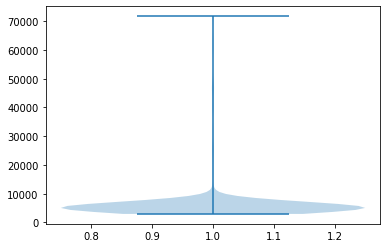

In [36]:
plt.figure()
plt.violinplot(gpfinals[:,0])

{'bodies': [<matplotlib.collections.PolyCollection at 0x1a2c8372e08>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1a2c82d94c8>,
 'cmins': <matplotlib.collections.LineCollection at 0x1a2c837bd08>,
 'cbars': <matplotlib.collections.LineCollection at 0x1a2c837bc88>}

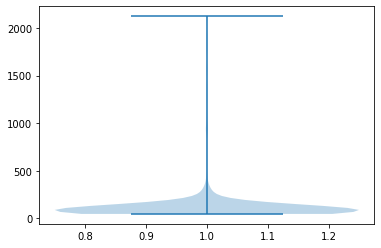

In [37]:
plt.figure()
plt.violinplot(gpfinals[:,1])

In [41]:
gpci_0 = sorted(gpfinals[:,0])
print(gpci_0[20], gpci_0[-21])

3890.380463360854 7498.014835928781


In [42]:
gpci_1 = sorted(gpfinals[:,1])
print(gpci_1[20], gpci_1[-21])

58.53453689687996 259.9460305403933


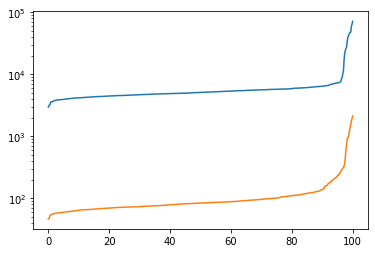

In [40]:
plt.figure()
plt.semilogy(np.linspace(0,100,len(gpci_0)), gpci_0)
plt.semilogy(np.linspace(0,100,len(gpci_1)), gpci_1)

# RTO style

In [50]:
# We will the GP model from above, since it seems relatively OK

# need to model the model error

In [94]:
# Dx = model.phi@cs
# f(x;theta): model.model(stuff)

merrfn = ca.Function('merr', [solver_setup['x']], 
                     [model.xdash[:, i]
                       - model.model(model.observation_times, *model.cs, *model.ps)[:, i]
                      for i in range(model.s)])

In [95]:
model_error = merrfn(solref)

(0.8173084259033203, 1.426074834392707e-14)
(0.8601073026657104, 1.367518294784209e-12)
(0.8384461998939514, 1.2220229710958874e-13)
(0.5124450922012329, 2.9996543206112084e-23)
(0.7307533025741577, 9.711329520402222e-18)
(0.8275172710418701, 3.932633366632472e-14)
(0.6789535284042358, 2.7412747405431438e-19)
(0.6983720660209656, 9.89386284578884e-19)
(0.7810161709785461, 5.211629082426587e-16)


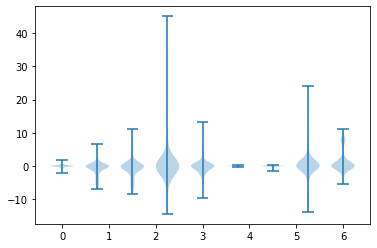

In [96]:
plt.violinplot([m.toarray().flatten() for m in model_error], 
               positions=np.arange(0, len(model_error)*0.75, 0.75))
for state in model_error:
    print(stats.shapiro(state))

In [142]:
dmflat = [m.toarray().flatten().reshape(-1,1) for m in model_error]

NormaltestResult(statistic=array([31.58016336]), pvalue=array([1.38820837e-07]))


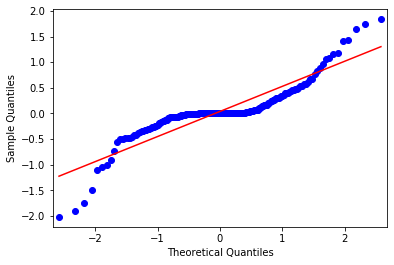

In [143]:
qqplot(np.array([sorted(d) for d in dmflat][0]), line='s')
print(stats.normaltest(np.array([sorted(d) for d in dmflat][0])))
# print(stats.anderson(np.array([sorted(d) for d in dmflat][0])))

In [144]:
me = stats.cauchy(*stats.cauchy.fit(dmflat[0]))
mg = stats.norm(*stats.norm.fit(dmflat[0]))

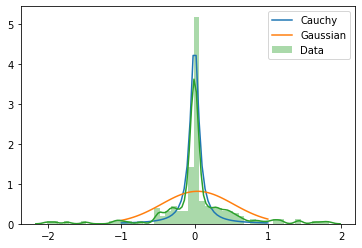

In [145]:
plt.plot(np.linspace(-1,1), me.pdf(np.linspace(-1,1)), label='Cauchy')
plt.plot(np.linspace(-1,1), mg.pdf(np.linspace(-1,1)), label='Gaussian')
sns.distplot(dmflat[0], label='Data')
plt.legend()


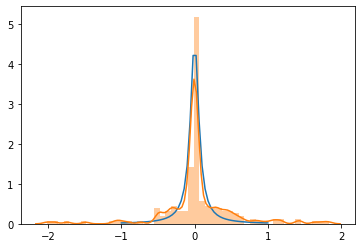

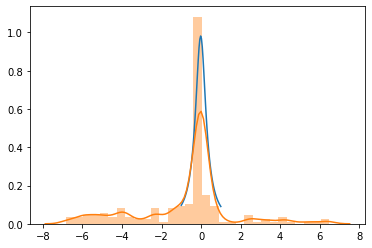

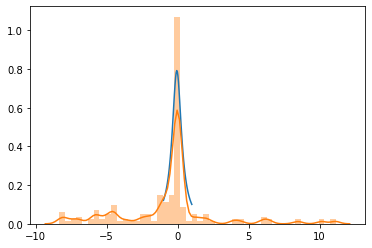

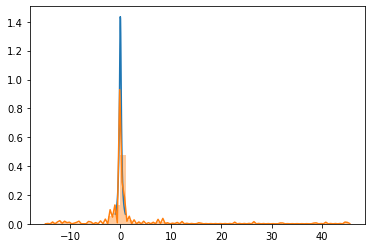

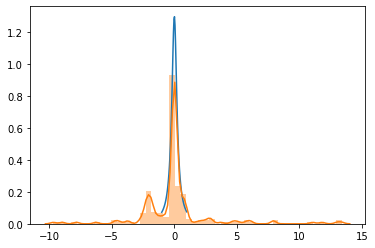

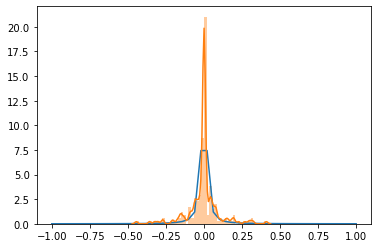

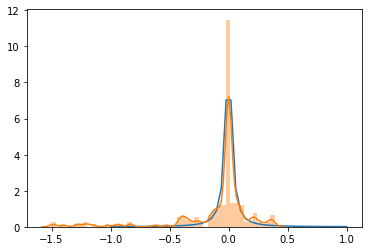

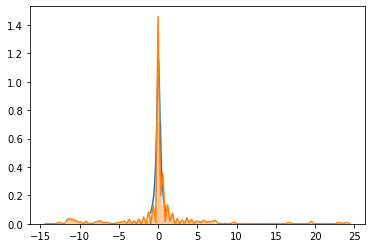

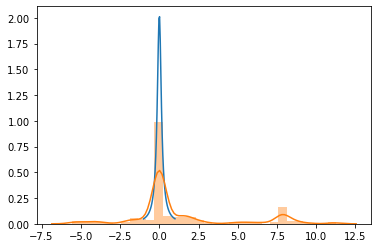

In [141]:
me_cauchies = []
for d in dmflat:
    me_cauchies.append(stats.cauchy(*stats.cauchy.fit(d)))
    plt.figure()
    plt.plot(np.linspace(-1,1), me_cauchies[-1].pdf(np.linspace(-1,1)))
    sns.distplot(d)

In [158]:
def resample_model_error(frozen_dists):
    out = []
    for dist in frozen_dists:
        out.append(dist.rvs(size=(model.n, ), random_state=None))
    return np.vstack(out)

In [193]:
mer = resample_model_error(me_cauchies)
mer.shape

(9, 200)

In [265]:
# modify objective.obj2
objective.r = ca.SX.sym('r', 200, 9)
objective.y = ca.SX.sym('y', *data_pd.shape)
objective.obj_1 = sum(w/objective.y.shape[0] * ca.sumsqr(objective.densities*( 
                            objective.y[:,i] - cm@ca.interp1d(model.observation_times,
                            om(model.observation_times, model.ps, 
                               *(model.xs[j] for j in oj)),
                            objective.observation_times)
                        ))
                         for i, (om, oj, w, cm) in enumerate(zip(objective.observation_model,
                                                      objective.observation_vector,
                                                      objective.weightings,
                                                      objective.collocation_matrices)))
objective.obj_2 = ca.sumsqr(model.xdash -model.model(model.observation_times, *model.cs, *model.ps) - objective.r)
objective.objective = objective.obj_1 + objective.rho*objective.obj_2 + objective.alpha*objective.regularisation

In [310]:
resample_opts = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.vcat([objective.rho, objective.alpha, 
                  ca.reshape(objective.y, (-1,1)), ca.reshape(objective.r, (-1,1))]),
    'g': ca.vcat(model.xs),
}
resample_solver = ca.nlpsol('resampler', 'ipopt', resample_opts, ipopt_opts)

In [ ]:
# compute y
resample_ys = yg # sample length 500
# compute r
resample_rs = [resample_model_error(me_cauchies) for _ in resample_ys]

# hold sols
resample_rto_sols = []
# run solver
for y, r in zip(resample_ys, resample_rs):
    yf = np.hstack(objective.observations_from_pandas(y).T)[:np.prod(objective.y.shape)]
    resample_run_opts = {
        'x0': solref,
        'p': [rho, alpha, *yf, *r.reshape(-1,1)],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 100000,
    }
    resample_rto_sols.append(resample_solver(**resample_run_opts))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     6822
Number of nonzeros in Lagrangian Hessian.............:     7264

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 7

  50 9.6275569e+006 0.00e+000 2.10e+003  -1.0 3.23e+004    -  2.37e-001 5.02e-002f  3
 100 9.5029453e+006 0.00e+000 1.46e+003  -2.5 6.13e+002  -8.9 1.00e+000 1.00e+000f  1
 150 9.4898210e+006 0.00e+000 6.53e+002  -2.5 1.45e+002  -8.6 1.00e+000 1.00e+000f  1
 200 9.4613961e+006 0.00e+000 6.79e+002  -2.5 1.05e+002  -9.2 1.00e+000 1.00e+000f  1
 250 9.4587768e+006 0.00e+000 3.12e+001  -2.5 9.12e+002    -  1.00e+000 2.50e-001f  3
 300 9.4584252e+006 0.00e+000 1.10e+002  -2.5 1.71e+002  -8.9 1.00e+000 5.00e-001f  2
 350 9.4576907e+006 0.00e+000 1.54e+002  -2.5 1.83e+002 -11.0 1.00e+000 1.00e+000f  1
 400 9.4561804e+006 0.00e+000 1.77e+002  -2.5 5.84e+002 -10.3 1.00e+000 1.00e+000f  1
 450 9.4531584e+006 0.00e+000 3.20e+001  -2.5 1.33e+001  -6.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 9.4491163e+006 0.00e+000 6.11e+001  -2.5 1.04e+001  -8.9 1.00e+000 1.00e+000f  1
 550 9.4465715e+006 0.00e+000 2.27e+002  -2.5 1.24e+003    

 250 2.7363835e+004 0.00e+000 3.40e+000  -5.7 3.89e+002 -10.1 1.00e+000 1.00e+000f  1
 300 2.7361084e+004 0.00e+000 2.15e-004  -8.6 5.83e-003  -4.3 1.00e+000 1.00e+000f  1
 350 2.7356739e+004 0.00e+000 7.98e-001  -8.6 9.64e+002    -  1.00e+000 1.96e-001f  1

Number of Iterations....: 367

                                   (scaled)                 (unscaled)
Objective...............:  1.5907355469190279e+002   2.7356300618048168e+004
Dual infeasibility......:  5.0668836426619246e-011   8.7136540321737210e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035596948514e-009   4.3094687380075781e-007
Overall NLP error.......:  2.5059035596948514e-009   4.3094687380075781e-007


Number of objective function evaluations             = 657
Number of objective gradient evaluations             = 368
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 657
Number of equality

1000 2.1947425e+005 0.00e+000 1.82e+002  -2.5 8.43e+000  -8.7 1.00e+000 1.00e+000f  1
1050 2.1891292e+005 0.00e+000 6.80e+002  -2.5 6.35e+000  -9.5 1.00e+000 1.00e+000f  1
1100 2.1858218e+005 0.00e+000 2.17e+002  -2.5 1.72e+001  -9.8 1.00e+000 1.00e+000f  1
1150 2.1847872e+005 0.00e+000 1.01e+002  -2.5 4.61e+004    -  1.00e+000 6.16e-003f  7
1200 2.1832554e+005 0.00e+000 4.37e+002  -3.8 1.91e+004    -  1.00e+000 8.41e-002f  4

Number of Iterations....: 1232

                                   (scaled)                 (unscaled)
Objective...............:  3.9328483021628739e+002   2.1828530622998875e+005
Dual infeasibility......:  7.9932664843846281e-009   4.4365113736073746e-006
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059174942066342e-009   1.3908621070107264e-006
Overall NLP error.......:  7.9932664843846281e-009   4.4365113736073746e-006


Number of objective function evaluations             = 2451
Number of objective

 550 5.6300655e+005 0.00e+000 2.47e+002  -2.5 1.60e+003 -11.5 1.00e+000 5.00e-001f  2
 600 5.6289680e+005 0.00e+000 2.54e+002  -2.5 5.68e+003    -  1.00e+000 1.25e-001f  4
 650 5.6244513e+005 0.00e+000 6.82e+001  -3.8 3.33e-001  -3.8 1.00e+000 1.00e+000f  1
 700 5.6231203e+005 0.00e+000 9.69e+001  -3.8 5.07e+001 -10.5 1.00e+000 1.00e+000f  1
 750 5.6226328e+005 0.00e+000 5.31e+002  -3.8 1.31e+000  -5.8 1.00e+000 5.00e-001f  2
 800 5.6223628e+005 0.00e+000 4.45e+001  -3.8 1.53e+004 -11.7 1.00e+000 6.25e-002f  5
 850 5.6222428e+005 0.00e+000 1.16e+002  -3.8 7.61e+001    -  1.00e+000 1.00e+000h  1
 900 5.6220091e+005 0.00e+000 1.46e-008  -5.7 9.57e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 907

                                   (scaled)                 (unscaled)
Objective...............:  6.0563981892403115e+002   5.6220088870566408e+005
Dual infeasibility......:  5.6475274296569101e-010   5.2424639872316482e-007
Constraint violation....:  0.0000000000000000e+000   0.

  50 2.3138750e+005 0.00e+000 1.64e+002  -1.7 1.27e+002  -6.4 1.00e+000 5.00e-001f  2
 100 2.2688321e+005 0.00e+000 1.89e+001  -3.8 3.80e+004    -  3.62e-001 5.35e-002f  5
 150 2.2671659e+005 0.00e+000 1.59e+000  -3.8 1.16e+000  -6.1 1.00e+000 1.00e+000f  1
 200 2.2665966e+005 0.00e+000 1.54e-001  -5.7 5.45e+000  -6.9 1.00e+000 1.00e+000f  1
 250 2.2657711e+005 0.00e+000 8.40e+000  -5.7 1.16e+002  -8.1 1.00e+000 6.25e-002f  5
 300 2.2653139e+005 0.00e+000 1.93e-001  -5.7 4.37e-001  -5.8 1.00e+000 1.00e+000f  1
 350 2.2649218e+005 0.00e+000 1.26e-002  -5.7 2.54e-001  -5.3 1.00e+000 1.00e+000f  1
 400 2.2645901e+005 0.00e+000 7.18e-001  -5.7 1.76e+000  -6.6 1.00e+000 1.00e+000f  1
 450 2.2640853e+005 0.00e+000 1.99e+001  -5.7 2.79e+001  -7.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 2.2630489e+005 0.00e+000 4.28e+001  -5.7 1.35e+004    -  4.14e-001 3.89e-002f  3
 550 2.2617216e+005 0.00e+000 6.25e+002  -5.7 1.59e+004    

  50 4.7844097e+006 0.00e+000 4.39e+001  -1.0 7.53e+002  -8.8 1.00e+000 1.00e+000f  1
 100 4.2088674e+006 0.00e+000 2.17e+002  -3.8 1.02e+003 -11.1 1.00e+000 7.19e-001f  1
 150 4.2069310e+006 0.00e+000 1.08e+002  -3.8 2.69e+003    -  1.00e+000 2.50e-001f  3
 200 4.2048951e+006 0.00e+000 1.84e+002  -3.8 7.16e+002 -10.7 1.00e+000 5.00e-001f  2
 250 4.1841620e+006 0.00e+000 1.68e-001  -3.8 3.21e+001  -7.9 1.00e+000 1.00e+000f  1
 300 4.1814646e+006 0.00e+000 1.21e+001  -3.8 1.67e+002  -9.5 1.00e+000 1.00e+000f  1
 350 4.1809867e+006 0.00e+000 5.78e+000  -3.8 6.27e+001  -9.3 1.00e+000 1.00e+000f  1
 400 4.1789611e+006 0.00e+000 5.68e+001  -3.8 2.73e+002  -9.2 1.00e+000 5.00e-001f  2
 450 4.1664700e+006 0.00e+000 7.45e+001  -3.8 5.68e+001  -8.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 4.1464611e+006 0.00e+000 7.61e+001  -3.8 5.95e+001  -9.0 1.00e+000 1.00e+000f  1
 550 4.1420299e+006 0.00e+000 1.03e+001  -3.8 5.94e+001  -9

  50 1.0583614e+006 0.00e+000 2.41e+003  -1.0 1.37e+004    -  2.73e-001 5.22e-002f  5
 100 1.0479250e+006 0.00e+000 2.25e+001  -1.0 7.00e+001  -7.3 1.00e+000 1.00e+000f  1
 150 1.0304279e+006 0.00e+000 1.37e+002  -2.5 9.36e+002 -10.6 1.00e+000 5.00e-001f  2
 200 1.0301783e+006 0.00e+000 3.25e+002  -2.5 3.00e+002  -9.6 1.00e+000 1.00e+000f  1
 250 1.0299884e+006 0.00e+000 5.20e+002  -2.5 1.16e+002 -10.3 1.00e+000 1.00e+000f  1
 300 1.0298207e+006 0.00e+000 4.94e+002  -2.5 2.02e+002 -10.1 1.00e+000 5.00e-001f  2
 350 1.0296627e+006 0.00e+000 2.27e+002  -2.5 4.87e+002 -10.7 1.00e+000 1.25e-001f  4
 400 1.0295231e+006 0.00e+000 1.00e+002  -2.5 7.47e+001 -10.0 1.00e+000 1.00e+000f  1
 450 1.0293999e+006 0.00e+000 1.51e+002  -2.5 1.90e+002    -  1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.0293099e+006 0.00e+000 5.77e+001  -2.5 1.78e+001 -10.8 1.00e+000 1.00e+000f  1
 550 1.0292543e+006 0.00e+000 2.32e+000  -2.5 7.50e+000    

Total number of variables............................:      366
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 3.1087369e+005 0.00e+000 9.90e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
  50 1.6392837e+005 0.00e+000 2.62e+002  -1.7 8.52e+003    -  1.26e-001 9.25e-003f  6
 100 1.6401616e+005 0.00e+000 1.08e+001  -1.7 3.48e+000  -5.4 1.00e+000 1.00e+000f  1
 150 1.6418232e+005 0.00e+000 9.43e+002  -1.7 9.40e+001  -7.1 1.00e+000 1.00e+000f  

 100 1.0022369e+005 0.00e+000 4.54e+001  -1.0 2.09e+001  -6.3 1.00e+000 1.00e+000f  1
 150 9.4617567e+004 0.00e+000 2.69e+003  -1.0 5.17e+003    -  1.00e+000 5.00e-001f  2
 200 8.3218660e+004 0.00e+000 5.94e+000  -2.5 2.90e+001  -8.8 1.00e+000 1.00e+000f  1
 250 8.3185405e+004 0.00e+000 6.43e+001  -2.5 5.21e+001 -10.3 1.00e+000 1.00e+000f  1
 300 8.3173584e+004 0.00e+000 6.90e-003  -2.5 4.53e-001    -  1.00e+000 1.00e+000h  1
 350 8.3034483e+004 0.00e+000 5.19e+002  -3.8 1.20e+002  -9.4 1.00e+000 1.00e+000f  1
 400 8.3013385e+004 0.00e+000 2.94e+002  -3.8 8.37e+001  -9.3 1.00e+000 1.00e+000f  1
 450 8.2998366e+004 0.00e+000 1.40e+001  -3.8 2.08e+001  -8.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 8.2982344e+004 0.00e+000 1.73e+001  -3.8 3.18e+001  -9.1 1.00e+000 1.00e+000f  1
 550 8.2969985e+004 0.00e+000 3.35e+001  -3.8 3.04e+001  -9.0 1.00e+000 1.00e+000f  1
 600 8.2960023e+004 0.00e+000 1.09e+002  -3.8 8.42e+001  -9

  50 1.9035336e+005 0.00e+000 6.02e+003  -1.0 1.88e+004    -  7.60e-001 2.50e-001f  3
 100 1.7575687e+005 0.00e+000 5.00e+003  -1.0 4.82e+002  -7.6 1.00e+000 1.00e+000f  1
 150 1.4807211e+005 0.00e+000 1.74e+001  -2.5 2.24e+002  -8.6 1.00e+000 1.00e+000f  1
 200 1.4786116e+005 0.00e+000 5.62e+001  -2.5 7.74e+001  -9.5 1.00e+000 1.00e+000f  1
 250 1.4779514e+005 0.00e+000 5.53e+001  -2.5 5.78e+001  -9.8 1.00e+000 1.00e+000f  1
 300 1.4772438e+005 0.00e+000 2.49e+002  -2.5 8.61e+002    -  1.00e+000 1.25e-001f  4
 350 1.4765712e+005 0.00e+000 2.40e+001  -2.5 3.67e+002 -11.1 1.00e+000 5.00e-001f  2
 400 1.4759345e+005 0.00e+000 4.25e+001  -2.5 6.90e+001 -11.6 1.00e+000 1.00e+000f  1
 450 1.4754019e+005 0.00e+000 1.26e+002  -2.5 2.24e+000  -8.0 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 1.4716513e+005 0.00e+000 4.00e+002  -3.8 2.45e+002  -9.3 1.00e+000 1.00e+000f  1
 550 1.4703631e+005 0.00e+000 2.03e+002  -3.8 7.36e+002 -10

 400 6.8193665e+004 0.00e+000 9.19e-001  -5.7 4.89e+000  -7.8 1.00e+000 1.00e+000f  1
 450 6.8192479e+004 0.00e+000 1.67e+001  -5.7 2.48e+000  -7.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500 6.8192296e+004 0.00e+000 1.89e+000  -5.7 1.88e+000  -6.9 1.00e+000 5.00e-001f  2
 550 6.8191588e+004 0.00e+000 2.72e+000  -5.7 7.09e+000  -8.5 1.00e+000 1.00e+000h  1
 600 6.8191212e+004 0.00e+000 3.26e-001  -5.7 1.65e+000  -8.1 1.00e+000 1.00e+000h  1
 650 6.8190741e+004 0.00e+000 1.75e+000  -5.7 6.55e+000  -8.8 1.00e+000 1.00e+000h  1
 700 6.8190222e+004 0.00e+000 2.01e-001  -5.7 3.21e+000  -8.6 1.00e+000 1.00e+000h  1
 750 6.8189758e+004 0.00e+000 1.71e+001  -5.7 2.66e+001  -9.7 1.00e+000 1.00e+000h  1


In [ ]:
final_comps_rto = []
for r in resample_rto_sols:
    x = getx(r['x'])
    final_comps_rto.append((x[-2][-1],x[-3][-1]))
final_comps_rto = np.array(final_comps_rto)

In [ ]:
plt.violinplot(final_comps_rto[:,0])

In [ ]:
plt.violinplot(final_comps_rto[:,1])